#### Explore the ready dataset Insights,distribution,charachtristics ...

In [1]:

from modbus import ModbusDataset,ModbusFlowStream
import pandas as pd 
import re   
import pickle
# import torch
from torch.utils.data import DataLoader
import numpy as np
# import json
from utils import merge_datasets,load_scalers
from collections import Counter
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from random import SystemRandom


In [3]:
# #Uncommit if the Labeled_CICMODBUS2023.zip not extracted yet! 
# import zipfile

# # from Labeling notebook , This file will be achieved.
# zip_path = "./Labeled_CICMODBUS2023.zip"
# extract_dir = "./dataset"

# # Create directory if missing
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)



In [2]:
# dataset_directory = "./dataset" # change this to the folder contain benign and attack subdirs
dataset_directory = "./ModbusDataset" # change this to the folder contain benign and attack subdirs

modbus = ModbusDataset(dataset_directory,"ready")
modbus.summary_print()

 The CIC Modbus Dataset contains network (pcap) captures and attack logs from a simulated substation network.
                The dataset is categorized into two groups: an attack dataset and a benign dataset
                The attack dataset includes network traffic captures that simulate various types of Modbus protocol attacks in a substation environment.
                The attacks are reconnaissance, query flooding, loading payloads, delay response, modify length parameters, false data injection, stacking Modbus frames, brute force write and baseline replay.
                These attacks are based of some techniques in the MITRE ICS ATT&CK framework.
                On the other hand, the benign dataset consists of normal network traffic captures representing legitimate Modbus communication within the substation network.
                The purpose of this dataset is to facilitate research, analysis, and development of intrusion detection systems, anomaly detection algorithms and

In [3]:
def find_global_stats(csv_files,category,return_fitted_scalers=False,save_scalers=False,scaler_dir='fitted_scalers',
                      unuseful_features = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp']):
    """
    Analyzes multiple CSV files, grouped by their subdirectory, to calculate global statistics
    (count, mean, std, min, max, duplicates) for numeric features and label counts for the 'Label' column.
    It can also return and save fitted MinMaxScaler and StandardScaler objects for future use.

    Args:
        csv_files (list): CSV dataset files to be analyzed.
        category (str): A string representing the category of the Attack scenario 
        return_fitted_scalers (bool, optional): If True, the function will return a dictionary
                                                of fitted MinMaxScaler and StandardScaler objects
                                                for each numeric column and save them to disk.
                                                Defaults to False.
        unuseful_features (list, optional): A list of column names to be excluded from the
                                            numeric feature analysis. Defaults to
                                            ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'].
        save_scalers: If True, saves the fitted scalers to disk. Defaults to False.
        scaler_dir (str, optional): Directory to save the scalers. Defaults to 'fitted_scalers'.

    Returns:
        tuple: A tuple containing:
            - all_global_stats (dict): A nested dictionary where the first level keys are
                                       subdirectory names. The second level contains another
                                       dictionary with numeric column names as keys, and
                                       their calculated statistics (count, mean, std, min, max, duplicates)
                                       as values.
            - all_label_counts (dict): A dictionary where keys are subdirectory names and values
                                       are dictionaries of label counts for the 'Label' column
                                       within each subdirectory's files.
            - all_fitted_scalers (dict, optional): Returned only if `return_fitted_scalers` is True.
                                                  A dictionary where keys are subdirectory names,
                                                  and values are dictionaries containing fitted
                                                  MinMaxScaler and StandardScaler objects for each
                                                  numeric column.
            - numeric_cols (list, optional): Returned only if `return_fitted_scalers` is True.
                                            A list of the numeric columns for which statistics
                                            and scalers were calculated.
    """
    print("-"*40,category,"-"*40)
    # Group files by their subdirectory
    dir_groups = {}
    for file in csv_files:
        subdir = os.path.basename(os.path.dirname(os.path.dirname(file)))
        # Clean subdirectory name by removing '-network-capture' and '-wide-pcap-capture'
        subdir = re.sub(r'-(network|wide)-(pcap-)?capture(s?)', '', subdir)
        if subdir not in dir_groups:
            dir_groups[subdir] = []
        dir_groups[subdir].append(file)
    
    all_global_stats = {}
    all_label_counts = {}
    if return_fitted_scalers:
        all_fitted_scalers = {} # To store the fitted MinMaxScaler and StandardScaler instances
    
    if save_scalers and not os.path.exists(scaler_dir):
        os.makedirs(scaler_dir)
        print(f"Created directory for scalers: {scaler_dir}")

    for subdir, files in dir_groups.items():
        # Read first file to get numeric columns
        first_df = pd.read_csv(files[0], encoding='cp1252')
        numeric_cols = first_df.drop(columns=unuseful_features, errors='ignore').select_dtypes(include=['number']).columns.tolist()
        # Initialize trackers for statistics
        stats = {
            col: {
                'count': 0, 
                'sum': 0.0, 
                'sum_sq': 0.0, 
                'min': float('inf'), 
                'max': float('-inf'),
                'duplicates': 0,
            } for col in numeric_cols
        }
        
        label_counts = Counter()
        unique_values = {col: set() for col in numeric_cols}
        len_csv_files = len(files)
        min_max_scalers = {col: MinMaxScaler() for col in numeric_cols}
        standard_scalers = {col: StandardScaler() for col in numeric_cols}

        for file_index,file in enumerate(files):
            # Read only necessary columns (numeric_cols + Label)
            print("node : ",subdir,", file_",file_index+1,"/",len_csv_files,":",file)
            df = pd.read_csv(file, encoding='cp1252', usecols=numeric_cols + ['Label'], low_memory=False)
            # Count labels in the current file
            if 'Label' in df.columns:
                label_counts.update(df['Label'])
            
            for col in numeric_cols:
                # Track unique values for duplicates
                current_values = set(df[col])
                stats[col]['duplicates'] += len(df[col]) - len(current_values - unique_values[col])
                unique_values[col].update(current_values)
                
                # Update other statistics (only for non-NaN values)
                valid_data = df[col]
                data_to_fit = valid_data.values.reshape(-1, 1) # Reshape for scikit-learn
                min_max_scalers[col].partial_fit(data_to_fit)
                standard_scalers[col].partial_fit(data_to_fit)
                
        
        # Compute final statistics for numeric columns
        feature = {}
        for col in numeric_cols:
            mm_scaler = min_max_scalers[col]
            std_scaler = standard_scalers[col]
            # The 'n_samples_seen_' attribute from StandardScaler gives the total count of samples seen
            sk_count = std_scaler.n_samples_seen_
            sk_mean = std_scaler.mean_[0]
            sk_std = np.sqrt(std_scaler.var_[0]) # Standard deviation is the square root of variance
            sk_min_val = mm_scaler.data_min_[0]
            sk_max_val = mm_scaler.data_max_[0]

            feature[col] = {
                'count':sk_count,
                'mean': sk_mean,
                'std': sk_std,
                'min': sk_min_val,
                'max': sk_max_val,
                'duplicates': stats[col]['duplicates']/ sk_count  
            }

        
        # Store results for this subdirectory
        all_global_stats[subdir] = feature
        all_label_counts[subdir] = dict(label_counts)
        # Store the fitted scaler objects for later use in scaling new data
        if save_scalers:
            scaler_subdir_path = os.path.join(scaler_dir, subdir)
            if not os.path.exists(scaler_subdir_path):
                os.makedirs(scaler_subdir_path)
            try:
                with open(os.path.join(scaler_subdir_path, 'min_max_scalers.pkl'), 'wb') as f:
                    pickle.dump(min_max_scalers, f)
                with open(os.path.join(scaler_subdir_path, 'standard_scalers.pkl'), 'wb') as f:
                    pickle.dump(standard_scalers, f)
                print(f"  > Scalers for '{subdir}' saved successfully.")
            except Exception as e:
                print(f"  [Error] Could not save scalers for '{subdir}'. Error: {e}")
            if return_fitted_scalers:
                all_fitted_scalers[subdir] = {
                    'min_max_scalers': min_max_scalers,
                    'standard_scalers': standard_scalers
                }

    if return_fitted_scalers:    
        return all_global_stats, all_label_counts ,all_fitted_scalers,numeric_cols
    else:
        return all_global_stats, all_label_counts


def print_statistics(_global_stats):

    for index, _global_stat in enumerate(_global_stats):
        global_stats_df = pd.DataFrame(_global_stats[_global_stat]).transpose()
        print("-"*80,"\nnode_", index," :",_global_stat,"\nflows count_",global_stats_df['count'].iloc[0])

        # Display with all rows and columns visible
        with pd.option_context('display.max_rows', None, 
                            'display.max_columns', None, 
                            'display.width', None,
                            'display.float_format', '{:.2f}'.format):  # Adjust decimal places as needed
            print(global_stats_df.drop(columns=['count']))


def plot_label_counts_subplots(all_label_counts, file_name="label_disto.pdf", ignore_network_wide=False):
    """
    Generates and saves a high-resolution plot of label distributions with log scale, dynamic bar widths,
    larger fonts, adjusted spacing, and annotations inside bars.

    Args:
        all_label_counts (dict): A dictionary where keys are subdirectory names
                                 and values are dictionaries of label counts.
        file_name (str): The name of the file to save the plot (e.g., 'plot.pdf').
        ignore_network_wide (bool): If True, excludes 'network-wide' and 'substation' subdirectories.
    """

    if ignore_network_wide:
        keys_to_remove = [
            subdir for subdir in all_label_counts
            if "network-wide" in subdir or "substation" in subdir
        ]
        for key in keys_to_remove:
            all_label_counts.pop(key)

    n_subdirs = len(all_label_counts)
    ncols = 2
    nrows = (n_subdirs + 1) //2

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), squeeze=False)
    axes = axes.flatten()

    for idx, (subdir, label_counts) in enumerate(all_label_counts.items()):
        labels = list(label_counts.keys())
        counts = list(label_counts.values())
        counts = [max(count, 1e-1) for count in counts]
        bar_width = 0.5
        bars = axes[idx].bar(labels, counts, color=['#36A2EB', '#FF6384', '#FFCE56', '#4BC0C0', '#9966FF'][:len(labels)], width=bar_width)
        axes[idx].set_title(f'Label Distribution: {subdir}', fontsize=14, pad=20)
        axes[idx].set_xlabel('Labels', fontsize=14)
        axes[idx].set_ylabel('Count (Log Scale)', fontsize=14)
        axes[idx].set_yscale('log')
        axes[idx].tick_params(axis='x', rotation=60, labelsize=12)
        axes[idx].tick_params(axis='y', labelsize=12)

        # Add count numbers inside each bar
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width() / 2, 
                height * 0.5,  # Place text at half the bar height
                f'{int(height)}' if height >= 1 else f'{height:.1f}', 
                ha='center', 
                va='center',  # Center vertically inside the bar
                fontsize=10,  # Smaller font for annotations inside bars
                color='Black'  # White text for contrast inside colored bars
            )
        axes[idx].set_ylim(1e-1, max(counts) * 2.0)  # Increased multiplier for more space above bars

    # Hide any unused subplots
    for idx in range(len(all_label_counts), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.savefig(file_name, dpi=300, format='pdf', bbox_inches='tight')
    print(f"Plot successfully saved to {file_name}")
    plt.show()

#### the ICS statistics and label distribution


- Extract min, max, mean , std and duplicate ratio for each numerical feature (mirror switch)
- Duplicates are between 0 and 1 (from no duplicate  to nearly almost)
- Calculate global min max of benign dataset numeric values for later min_max scaling 
- Extract charachtristics of the ❗network-wide benign❗ node data as a generalization to all dataset


In [6]:
# #pre calculated numeric_cols with the enhanced CICFlowMeter 2019 
# numeric_cols = ['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Bwd Act Data Pkts', 'Fwd Seg Size Min', 'Bwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'ICMP Code', 'ICMP Type', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time']
# ### needed for scaling  (will change numeric_cols)
benign_wide_dir =[col for col in modbus.dataset["benign_dataset_dir"] if col.find("network-wide") != -1]
benign_wide_global_stats,benign_wide_label_counts ,benign_scalers,numeric_cols=find_global_stats(
    benign_wide_dir,"benign",return_fitted_scalers=True,save_scalers=True,scaler_dir='fitted_scalers')


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

KeyboardInterrupt: 

In [ ]:
#you can use the loaded scalers instead of benign_scaler output of the find_global_stats
print("\n--- Loading scalers from disk ---")
loaded_scalers = load_scalers("fitted_scalers")



--- Loading scalers from disk ---
Successfully loaded scalers for 'network-wide'


In [ ]:

print_statistics(benign_wide_global_stats)
plot_label_counts_subplots(benign_wide_label_counts)
del benign_wide_label_counts,benign_wide_global_stats


-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 2822444.0
                                  mean          std   min            max  \
Protocol                          6.00         0.16  2.00          17.00   
Flow Duration              10297843.17  26824472.17  0.00   119999783.00   
Total Fwd Packet                  4.27         2.50  0.00         226.00   
Total Bwd packets                 3.30         1.65  0.00         210.00   
Total Length of Fwd Packet       17.41       189.83  0.00       52116.00   
Total Length of Bwd Packet        7.97        14.79  0.00        3914.00   
Fwd Packet Length Max             9.21        14.84  0.00         700.00   
Fwd Packet Length Min             0.01         1.08  0.00         118.00   
Fwd Packet Length Mean            1.92         7.00  0.00         230.60   
Fwd Packet Length Std             3.97         7.45  0.00         350.00   
Bwd Packet Length Max             

#### compare our custom memory-friend statistics with the built-in pandas 

In [ ]:
benign_wide_df = merge_datasets(benign_wide_dir) ##heavy memory usage (at least of 4 free GIG of RAM is suggested)
benign_wide_df=benign_wide_df.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'])

In [ ]:
pd.options.display.max_rows = 90
pd.options.display.max_columns= 90

benign_wide_df.describe().transpose().reset_index()  ##heavy memory usage (at least another 4 free GIG of RAM is suggested)

index      count          mean           std  min  \
0                     Protocol  2822444.0  6.002180e+00  1.555253e-01  2.0   
1                Flow Duration  2822444.0  1.029784e+07  2.682448e+07  0.0   
2             Total Fwd Packet  2822444.0  4.274185e+00  2.495789e+00  0.0   
3            Total Bwd packets  2822444.0  3.302945e+00  1.646330e+00  0.0   
4   Total Length of Fwd Packet  2822444.0  1.741455e+01  1.898308e+02  0.0   
5   Total Length of Bwd Packet  2822444.0  7.968790e+00  1.478770e+01  0.0   
6        Fwd Packet Length Max  2822444.0  9.206532e+00  1.484285e+01  0.0   
7        Fwd Packet Length Min  2822444.0  1.380718e-02  1.082329e+00  0.0   
8       Fwd Packet Length Mean  2822444.0  1.918787e+00  7.004023e+00  0.0   
9        Fwd Packet Length Std  2822444.0  3.973973e+00  7.452475e+00  0.0   
10       Bwd Packet Length Max  2822444.0  7.349643e+00  4.836642e+00  0.0   
11       Bwd Packet Length Min  2822444.0  5.291336e-02  1.000139e+00  0.0   
12      Bwd Packet Length Mean  2822444.0  1.791754e+00  1.483881e+00  0.0   
13       Bwd Packet Length Std  2822444.0  3.555710e+00  2.353485e+00  0.0   
14                Flow Bytes/s  2822444.0  4.826870e+03  9.188720e+03 -1.0   
15              Flow Packets/s  2822444.0  7.242185e+04  1.116218e+05 -1.0   
16               Flow IAT Mean  2822444.0  1.012355e+06  2.646567e+06  0.0   
17                Flow IAT Std  2822444.0  3.198117e+06  8.361389e+06  0.0   
18                Flow IAT Max  2822444.0  1.015280e+07  2.649460e+07  0.0   
19                Flow IAT Min  2822444.0  1.990097e+01  1.216385e+03  0.0   
20               Fwd IAT Total  2822444.0  1.028495e+07  2.682874e+07  0.0   
21                Fwd IAT Mean  2822444.0  2.017282e+06  5.289043e+06  0.0   
22                 Fwd IAT Std  2822444.0  4.514232e+06  1.182650e+07  0.0   
23                 Fwd IAT Max  2822444.0  1.014747e+07  2.651190e+07  0.0   
24                 Fwd IAT Min  2822444.0  2.232934e+02  1.223521e+05  0.0   
25               Bwd IAT Total  2822444.0  1.029760e+07  2.682430e+07  0.0   
26                Bwd IAT Mean  2822444.0  2.537684e+06  6.624643e+06  0.0   
27                 Bwd IAT Std  2822444.0  5.058276e+06  1.322335e+07  0.0   
28                 Bwd IAT Max  2822444.0  1.015269e+07  2.649442e+07  0.0   
29                 Bwd IAT Min  2822444.0  5.216772e+02  1.704884e+05  0.0   
30               Fwd PSH Flags  2822444.0  7.359916e-01  8.525842e-01  0.0   
31               Bwd PSH Flags  2822444.0  7.359126e-01  8.525899e-01  0.0   
32               Fwd URG Flags  2822444.0  0.000000e+00  0.000000e+00  0.0   
33               Bwd URG Flags  2822444.0  0.000000e+00  0.000000e+00  0.0   
34               Fwd RST Flags  2822444.0  3.758757e-01  4.843483e-01  0.0   
35               Bwd RST Flags  2822444.0  2.317495e-03  4.808456e-02  0.0   
36           Fwd Header Length  2822444.0  1.378631e+02  8.695155e+01  0.0   
37           Bwd Header Length  2822444.0  1.112715e+02  5.595668e+01  0.0   
38               Fwd Packets/s  2822444.0  3.642239e+04  5.569227e+04  0.0   
39               Bwd Packets/s  2822444.0  3.599947e+04  5.593194e+04  0.0   
40           Packet Length Min  2822444.0  1.350709e-02  1.080807e+00  0.0   
41           Packet Length Max  2822444.0  9.207567e+00  1.484552e+01  0.0   
42          Packet Length Mean  2822444.0  1.896022e+00  5.060917e+00  0.0   
43           Packet Length Std  2822444.0  3.713852e+00  6.674284e+00  0.0   
44      Packet Length Variance  2822444.0  5.833875e+01  7.693709e+02  0.0   
45              FIN Flag Count  2822444.0  1.401035e+00  4.970304e-01  0.0   
46              SYN Flag Count  2822444.0  1.401206e+00  9.159802e-01  0.0   
47              RST Flag Count  2822444.0  3.781932e-01  4.849363e-01  0.0   
48              PSH Flag Count  2822444.0  1.471904e+00  1.705123e+00  0.0   
49              ACK Flag Count  2822444.0  6.498133e+00  4.067873e+00  0.0   
50              URG Flag Count  2822444.0  0.00

In [ ]:

benign_wide_df

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0              6       91780087                24                 12   
1              6      101963027                24                 12   
2              6       96863625                32                 16   
3              6      107004998                16                  8   
4              6          40762                 2                  2   
...          ...            ...               ...                ...   
153373         6              9                 1                  1   
153374         6              7                 1                  1   
153375         6       71378604                 6                  5   
153376         6              8                 1                  1   
153377         6             12                 1                  1   

        Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                             3030                         228   
1                             3030                         228   
2                             4040                         304   
3                             2020                         152   
4                               10                           0   
...                            ...                         ...   
153373                           0                           0   
153374                           0                           0   
153375                          12                          11   
153376                           0                           0   
153377                           0                           0   

        Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                         253                      0                  126.25   
1                         253                      0                  126.25   
2                         253                      0                  126.25   
3                         253                      0                  126.25   
4                          10                      0                    5.00   
...                       ...                    ...                     ...   
153373                      0                      0                    0.00   
153374                      0                      0                    0.00   
153375                     12                      0                    2.00   
153376                      0                      0                    0.00   
153377                      0                      0                    0.00   

        Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                  128.965870                     19                     19   
1                  128.965870                     19                     19   
2                  128.270631                     19                     19   
3                  130.390951                     19                     19   
4                    7.071068                      0                      0   
...                       ...                    ...                    ...   
153373               0.000000                      0                      0   
153374               0.000000                      0                      0   
153375               4.898979                     11                      0   
153376               0.000000                      0                      0   
153377               0.000000                      0                      0   

        Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                         19.0                0.00000     35.497896   
1                         19.0                0.00000     31.952759   
2                         19.0                0.00000     44.846556   
3                         19.0                0.00000     20.298117   
4                          0.0                0.00000    245.326530   
...           

##### Identifying duplicate values


In [ ]:
# Types of attacks & normal instances (BENIGN)
print(benign_wide_df['Label'].value_counts()) 
dups = benign_wide_df[benign_wide_df.duplicated()] ## heavy memory usage (at least another 4 free GIG of RAM is suggested)
print(f'Number of duplicates: {len(dups)}')
del dups
benign_wide_df.drop_duplicates(inplace = True)
print("shape after drop duplicates",benign_wide_df.shape)
# Checking for columns with zero standard deviation (the blank squares in the heatmap)
std = benign_wide_df.std(numeric_only = True)
zero_std_cols = std[std == 0].index.tolist()
print("zero variance columns (will be droped for the following analysis )",zero_std_cols)
benign_wide_df.drop(columns=zero_std_cols,inplace=True)
print("shape after drop  zero variance ",benign_wide_df.shape)


Label
BENIGN    2822444
Name: count, dtype: int64
Number of duplicates: 13666
shape after drop duplicates (2808778, 88)
zero variance columns (will be droped for the following analysis ) ['Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'ICMP Code', 'ICMP Type']
shape after drop  zero variance  (2808778, 75)


In [ ]:
corr = benign_wide_df.corr(numeric_only = True).round(2)
corr.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 2)
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(corr, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()
del corr,benign_wide_df


#### Attack dataset Visualization for each Scenario 

In [ ]:

###(just for visualization) Uncomment if you want to create the attack plots and statistic tables on your own.

benign_global_stats, benign_label_counts= find_global_stats(modbus.dataset["benign_dataset_dir"] ,"benign",return_fitted_scalers=False)
ext_global_stats, ext_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["external"],"external")
com_ied_global_stats, com_ied_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-ied"],"compromised-ied")
com_scd_global_stats, com_scd_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-scada"],"compromised-scada")


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

In [ ]:

###(just for visualization) Uncomment if you want to create the attack plots and statistic tables on your own.

benign_global_stats, benign_label_counts= find_global_stats(modbus.dataset["benign_dataset_dir"] ,"benign",return_fitted_scalers=False)
ext_global_stats, ext_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["external"],"external")
com_ied_global_stats, com_ied_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-ied"],"compromised-ied")
com_scd_global_stats, com_scd_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-scada"],"compromised-scada")


---------------------------------------- external ----------------------------------------
node :  network-wide , file_ 1 / 2 : ./dataset/ModbusDataset/attack/external/network-wide/ready/network-wide-normal-1-labeled.csv
node :  network-wide , file_ 2 / 2 : ./dataset/ModbusDataset/attack/external/network-wide/ready/network-wide-normal-0-labeled.csv
node :  ied4c , file_ 1 / 1 : ./dataset/ModbusDataset/attack/external/ied4c/ied4c-network-capture/ready/veth8bc3408-0-labeled.csv
node :  external-attacker , file_ 1 / 1 : ./dataset/ModbusDataset/attack/external/external-attacker/external-attacker-network-capture/ready/veth665f3cf-0-labeled.csv
node :  ied1b , file_ 1 / 1 : ./dataset/ModbusDataset/attack/external/ied1b/ied1b-network-capture/ready/vethd9e14c0-0-labeled.csv
node :  scada-hmi , file_ 1 / 1 : ./dataset/ModbusDataset/attack/external/scada-hmi/scada-hmi-network-capture/ready/veth5bbeaa2-0-labeled.csv
node :  central-agent , file_ 1 / 1 : ./dataset/ModbusDataset/attack/external/cen

#### Benign 

---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

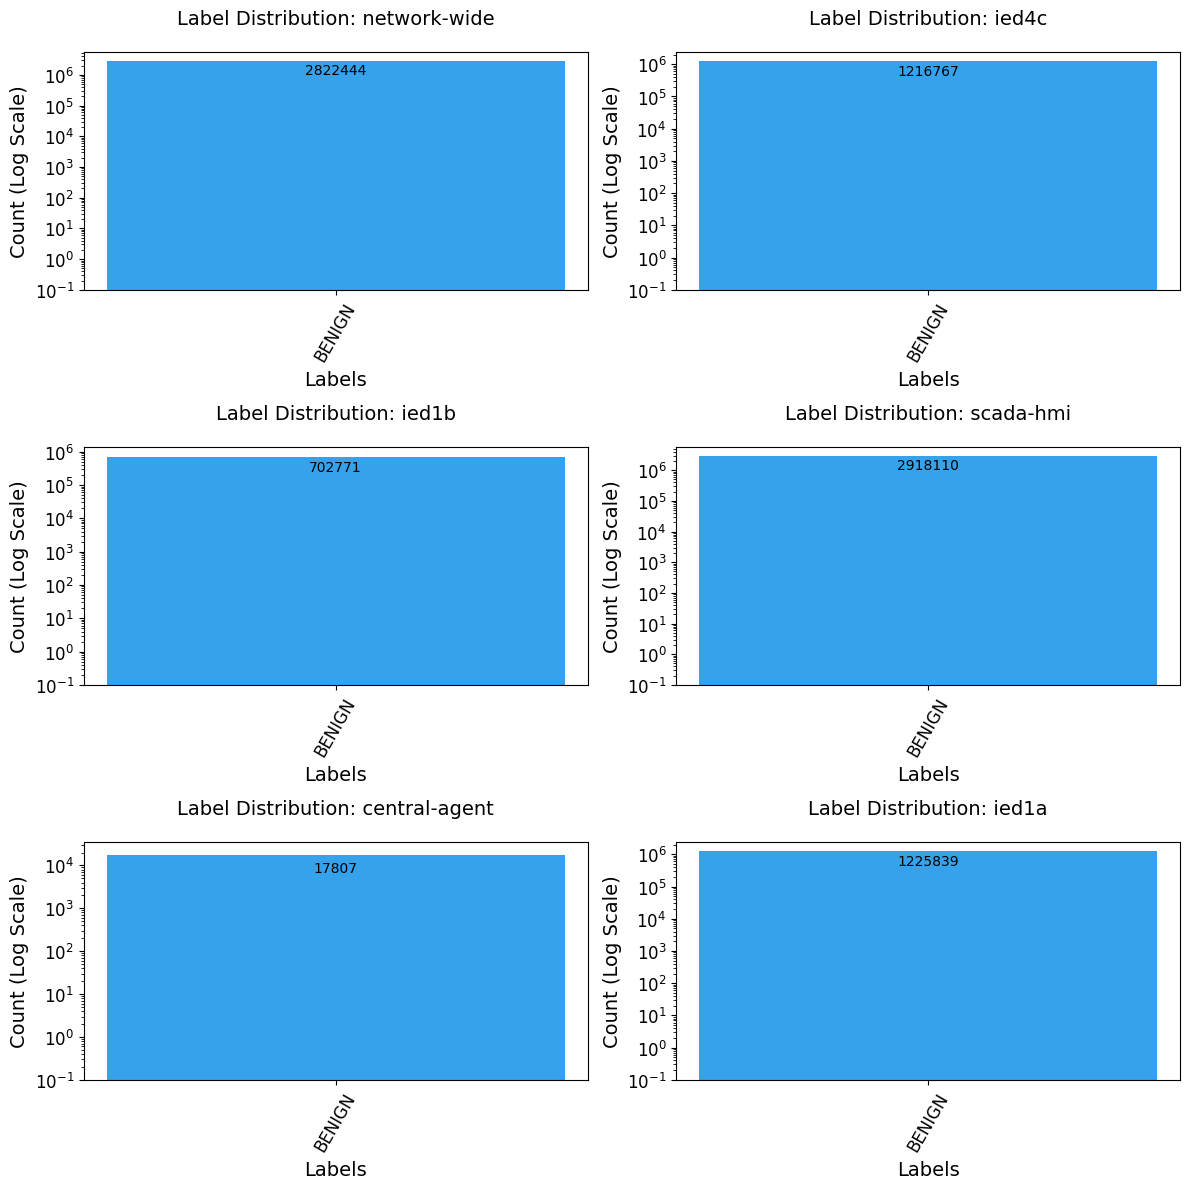

In [46]:

print_statistics(benign_global_stats)
plot_label_counts_subplots(benign_label_counts)


#### External Attacker

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 221329.0
                                  mean          std   min            max  \
Protocol                          6.00         0.13  2.00          17.00   
Flow Duration               7108321.29  22696854.83  0.00   119612092.00   
Total Fwd Packet                  4.26         2.12  0.00         244.00   
Total Bwd packets                 3.46         1.42  0.00         126.00   
Total Length of Fwd Packet       15.06       148.64  0.00       31874.00   
Total Length of Bwd Packet        5.53        12.18  0.00        2394.00   
Fwd Packet Length Max             9.95        12.26  0.00         276.00   
Fwd Packet Length Min             0.01         0.89  0.00         118.00   
Fwd Packet Length Mean            2.20         5.83  0.00         131.83   
Fwd Packet Length Std             4.51         6.23  0.00         146.07   
Bwd Packet Length Max             5

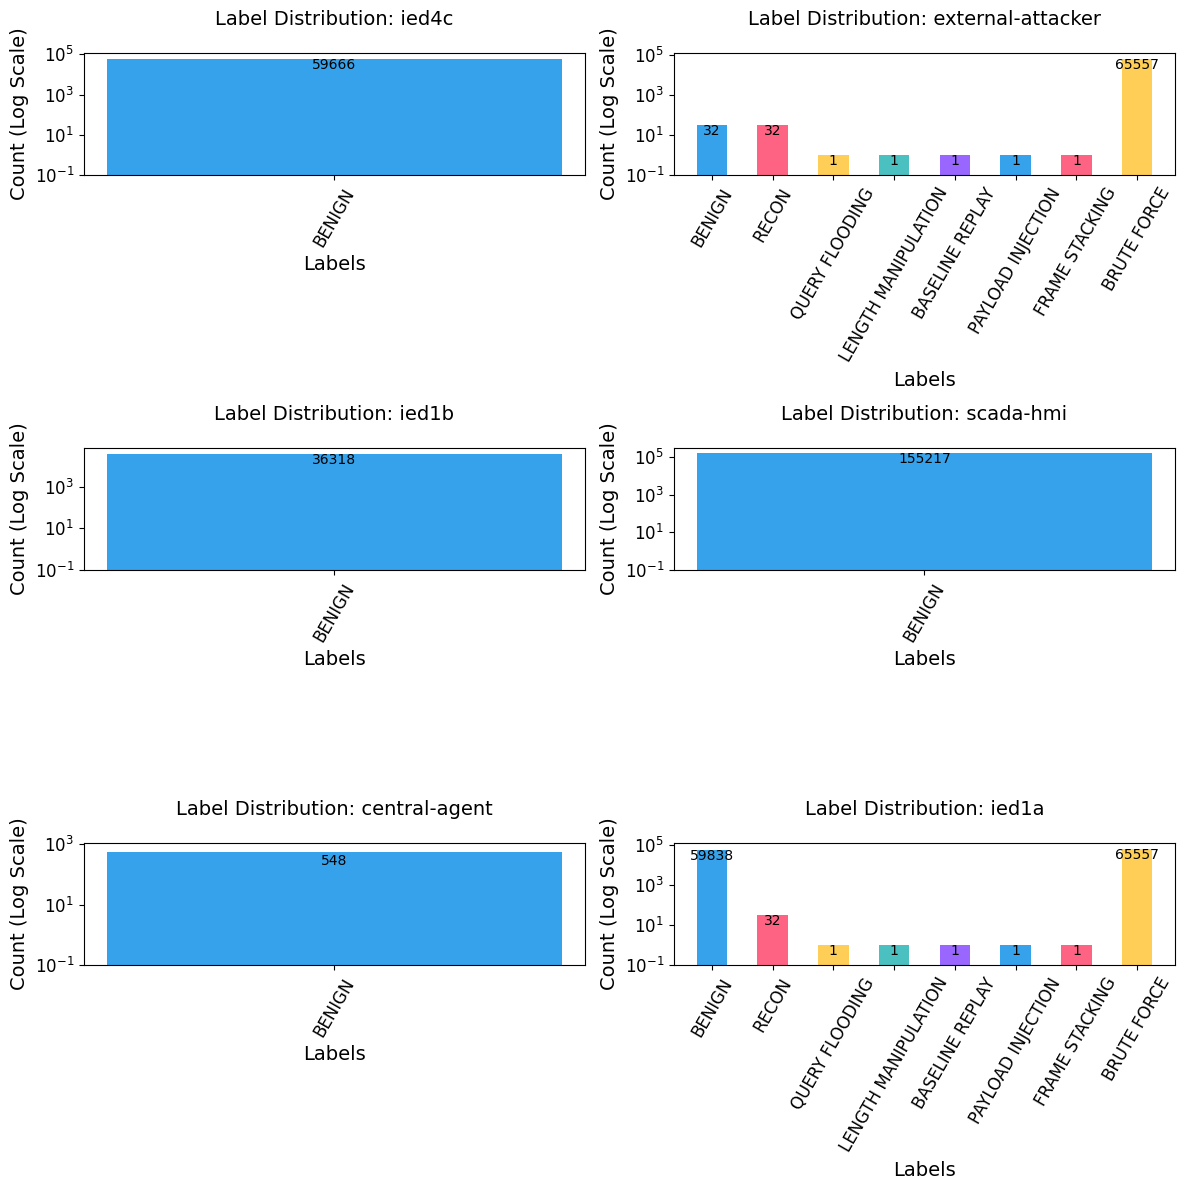

In [8]:

print_statistics(ext_global_stats)
plot_label_counts_subplots(ext_label_counts,"external_label_ditro.pdf",ignore_network_wide=True)


#### Compromised IED

In [4]:
com_ied_global_stats, com_ied_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-ied"],"compromised-ied")
com_scd_global_stats, com_scd_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-scada"],"compromised-scada")


---------------------------------------- compromised-ied ----------------------------------------
node :  ied4c , file_ 1 / 6 : ./ModbusDataset/attack/compromised-ied/ied4c/ied4c-network-captures/ready/vethe685ac9-0-labeled.csv
node :  ied4c , file_ 2 / 6 : ./ModbusDataset/attack/compromised-ied/ied4c/ied4c-network-captures/ready/vethe685ac9-5-labeled.csv
node :  ied4c , file_ 3 / 6 : ./ModbusDataset/attack/compromised-ied/ied4c/ied4c-network-captures/ready/vethe685ac9-1-labeled.csv
node :  ied4c , file_ 4 / 6 : ./ModbusDataset/attack/compromised-ied/ied4c/ied4c-network-captures/ready/vethe685ac9-2-labeled.csv
node :  ied4c , file_ 5 / 6 : ./ModbusDataset/attack/compromised-ied/ied4c/ied4c-network-captures/ready/vethe685ac9-4-labeled.csv
node :  ied4c , file_ 6 / 6 : ./ModbusDataset/attack/compromised-ied/ied4c/ied4c-network-captures/ready/vethe685ac9-3-labeled.csv
node :  ied1b , file_ 1 / 6 : ./ModbusDataset/attack/compromised-ied/ied1b/ied1b-network-captures/ready/vethc76bd3f-3-labe

In [5]:

print_statistics(com_ied_global_stats)
plot_label_counts_subplots(com_ied_label_counts,"comp_ied_label_ditro.pdf",ignore_network_wide=True)


-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 949637.0
                                   mean          std   min            max  \
Protocol                           6.01         0.25  2.00          17.00   
Flow Duration               11306483.16  28013926.62  0.00   119990244.00   
Total Fwd Packet                   3.62         2.57  0.00         118.00   
Total Bwd packets                  2.98         1.79  0.00          61.00   
Total Length of Fwd Packet        18.42       207.76  0.00       15409.00   
Total Length of Bwd Packet         6.97        16.16  0.00        1159.00   
Fwd Packet Length Max              8.11        16.80  0.00         700.00   
Fwd Packet Length Min              0.03         1.71  0.00         118.00   
Fwd Packet Length Mean             1.89         8.33  0.00         175.00   
Fwd Packet Length Std              3.60         8.49  0.00         350.00   
Bwd Packet Length Max          

#### Compromised SCADA

-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 839426.0
                                   mean           std   min             max  \
Protocol                           6.01          0.27  2.00           17.00   
Flow Duration               10097713.06   25868605.09  0.00    119999661.00   
Total Fwd Packet                   3.90          5.57  0.00          182.00   
Total Bwd packets                  3.14          3.12  0.00           99.00   
Total Length of Fwd Packet        46.01        711.73  0.00        25021.00   
Total Length of Bwd Packet         8.15         53.48  0.00         1881.00   
Fwd Packet Length Max              8.55         16.99  0.00          718.00   
Fwd Packet Length Min              0.04          1.88  0.00          118.00   
Fwd Packet Length Mean             2.04          8.51  0.00          179.50   
Fwd Packet Length Std              3.83          8.40  0.00          359.00   
Bwd Packe

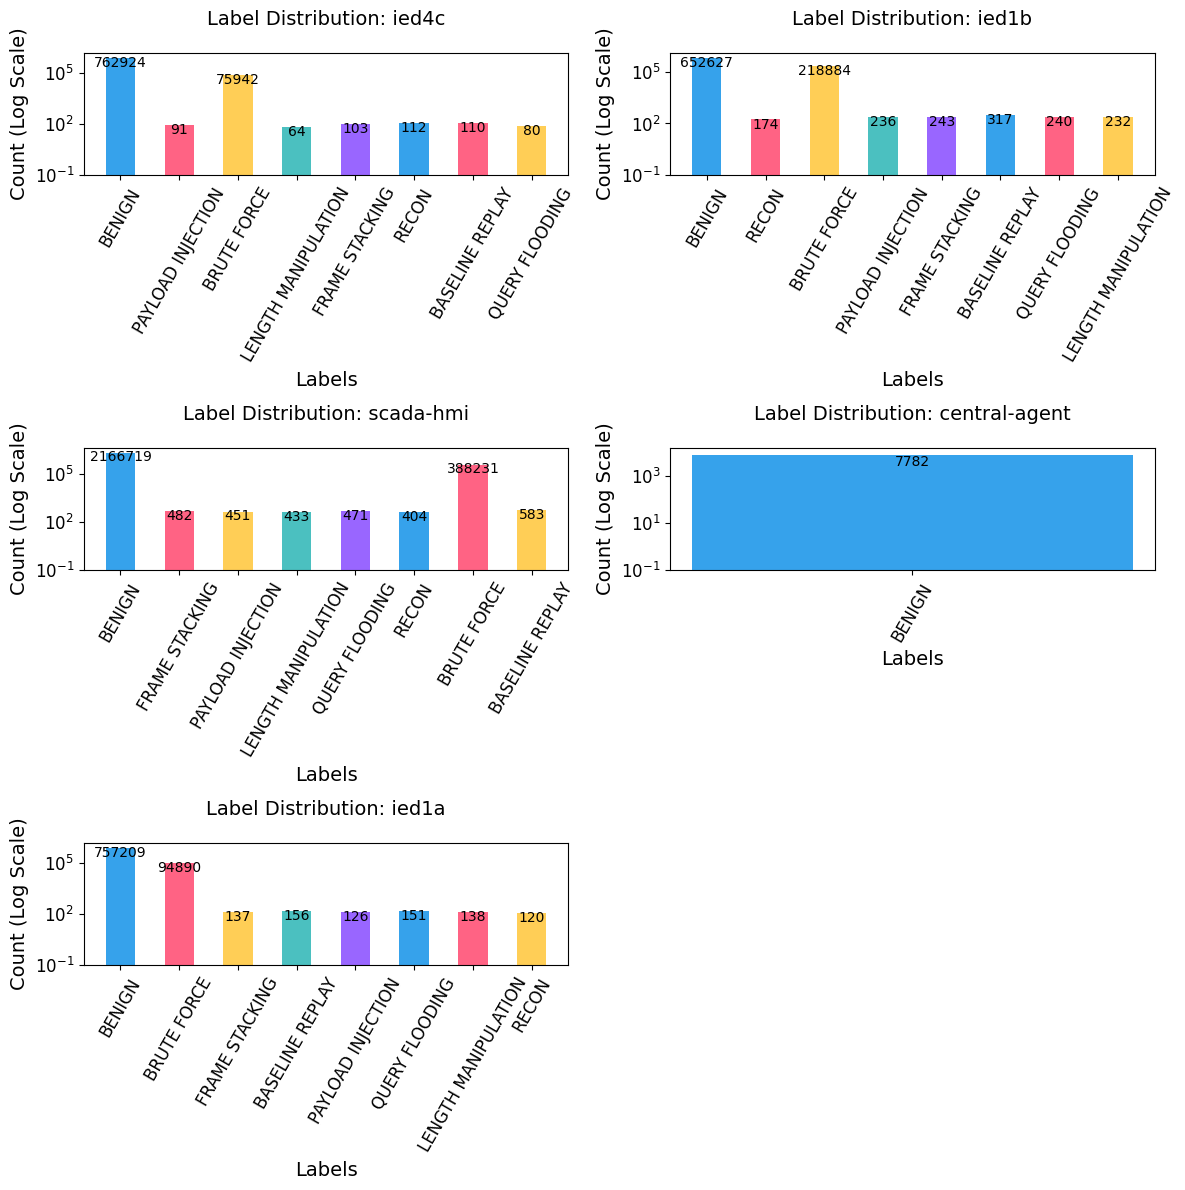

In [6]:

print_statistics(com_scd_global_stats)
plot_label_counts_subplots(com_scd_label_counts,"comp_scada_label_ditro.pdf",ignore_network_wide=True)


#### Ensure correct  Shuffling and Min Max interval after scaling [0 to 1]

##### The Analysis are on ied1b node dataset (compromised-scada scenario) because of having enough samples for diverse Categories

In [11]:
### for test performance of the machine learning algorithms on all attack categories (except Delay Response) 
### ied1b node of the compromised-scada scenario is suitable
csv_files=[col for col in modbus.dataset["attack_dataset_dir"]["compromised-scada"] if col.find("ied1b")!=-1]
print("ied1b number of csv files :",len(csv_files),csv_files)

## run benign_scalers cell or load from the saved scalers 
loaded_scalers = load_scalers("fitted_scalers")

dataset = ModbusFlowStream(csv_files=csv_files, chunk_size=1, scalers=loaded_scalers["network-wide"]["min_max_scalers"])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(f"Total batches in the dataset: {len(dataloader)}")
num_epochs = 3 
start_time =time.time()
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")

    start_time =time.time()
    for batch_idx, (features, labels) in enumerate(dataloader):

        print(f"  Batch {batch_idx + 1}: Features {features[0][0] }, Labels shape={labels.shape}")
        time.sleep(0.001)
        break

    print(f"Elapsed time: {(time.time() - start_time) * 1000:.2f} ms")


ied1b number of csv files : 8 ['./dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-6-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-3-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-4-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-1-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-7-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-0-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-5-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-2-labeled.csv']
Successfully loaded scalers for 'network-wide'
Total batches in t

#### Test two methods of shuffling (file indices,chunk rows)
 


In [12]:
loaded_scalers = load_scalers("fitted_scalers")

AE_dataset=ModbusFlowStream( 
    shuffle=False,chunk_size=1,batch_size=64,csv_files=modbus.dataset["benign_dataset_dir"][0:5],scalers=loaded_scalers['network-wide']['min_max_scalers'],window_size=1
)
AE_dataloader=DataLoader(AE_dataset,batch_size=1,shuffle=False)


Successfully loaded scalers for 'network-wide'


In [13]:
print("without shuffling")
for i in range(5):
    for sequences, _ in AE_dataloader:
        pass
    print(next(iter(AE_dataloader))[0][0][0][:] )
    print(AE_dataset.file_order_indices,AE_dataset.current_row_in_chunk_idx)
    AE_dataset.current_row_in_chunk_idx=0



without shuffling
tensor([8.9175e-01, 7.0796e-02, 3.8095e-02, 3.8760e-02, 3.8835e-02, 3.6143e-01,
        0.0000e+00, 5.4748e-01, 3.7255e-01, 1.2179e-01, 1.0000e+00, 3.8255e-01,
        0.0000e+00, 1.4485e-05, 3.6728e-06, 8.6928e-02, 1.8473e-01, 5.0971e-01,
        1.2998e-05, 8.9175e-01, 7.3598e-02, 2.0467e-01, 5.0952e-01, 1.8260e-06,
        8.9177e-01, 1.4281e-01, 2.7595e-01, 5.0971e-01, 2.0162e-04, 3.8835e-02,
        3.8835e-02, 0.0000e+00, 0.0000e+00, 7.0718e-02, 3.8050e-02, 8.9711e-07,
        4.4856e-07, 0.0000e+00, 3.6143e-01, 7.0423e-01, 4.4514e-01, 1.9815e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8835e-02, 5.5172e-02, 2.5000e-01,
        7.0423e-01, 5.4748e-01, 3.8255e-01, 4.4248e-02, 2.5827e-02, 1.9048e-02,
        2.5549e-02, 7.8144e-03, 7.6888e-03, 3.8835e-02, 3.8835e-02, 8.0000e-01,
        0.0000e+00, 3.2386e-03, 9.9740e-05, 2.2528e-03, 3.1468e-03, 2.9712e-01,
        2.9293e-01, 5.0971e-01, 1.6945e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.8796e-03, 0.

In [14]:
print("Test shuffling csv file indices per epoch (chunk_size =1)")
for i in range(5):
    # AE_dataset.current_row_in_chunk_idx=0
    for sequences, _ in AE_dataloader:
        pass
    sys_rand = SystemRandom()
    sys_rand.shuffle(AE_dataset.file_order_indices)
    print(next(iter(AE_dataloader))[0][0][0][:] )
    print(AE_dataset.file_order_indices,AE_dataset.current_row_in_chunk_idx)
    AE_dataset.current_row_in_chunk_idx=0



Test shuffling csv file indices per epoch (chunk_size =1)
tensor([9.7686e-01, 8.8496e-02, 4.7619e-02, 4.8450e-02, 4.8544e-02, 3.6143e-01,
        0.0000e+00, 5.4748e-01, 3.7009e-01, 1.2179e-01, 1.0000e+00, 3.8255e-01,
        0.0000e+00, 1.6433e-05, 3.7678e-06, 7.5522e-02, 1.4642e-01, 3.8219e-01,
        1.8996e-05, 9.7686e-01, 6.3649e-02, 1.6048e-01, 3.8205e-01, 2.1974e-06,
        9.7689e-01, 1.2167e-01, 2.0767e-01, 3.8219e-01, 2.0236e-04, 4.8544e-02,
        4.8544e-02, 0.0000e+00, 0.0000e+00, 8.8398e-02, 4.7562e-02, 1.0237e-06,
        5.1185e-07, 0.0000e+00, 3.6143e-01, 7.0423e-01, 4.4322e-01, 1.9644e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8544e-02, 6.8966e-02, 2.5000e-01,
        7.0423e-01, 5.4748e-01, 3.8255e-01, 4.4248e-02, 2.4215e-02, 1.9048e-02,
        2.4016e-02, 7.8144e-03, 7.6888e-03, 4.8544e-02, 4.8544e-02, 8.0000e-01,
        0.0000e+00, 4.7940e-03, 3.6520e-03, 6.2735e-03, 3.1938e-03, 2.4399e-01,
        1.6786e-01, 3.8219e-01, 1.2725e-01, 0.0000e+00, 0.0000

In [15]:
print("Test shuffling rows in each chunk (chunk_size =1)")
AE_dataset.shuffle=True
### test shuffling rows in each chunk 
for i in range(5):
    # AE_dataset.current_row_in_chunk_idx=0
    for sequences, _ in AE_dataloader:
        pass
    print(next(iter(AE_dataloader))[0][0][0][:] )
    print(AE_dataset.file_order_indices,AE_dataset.current_row_in_chunk_idx)
    AE_dataset.current_row_in_chunk_idx=0





Test shuffling rows in each chunk (chunk_size =1)
tensor([3.4941e-04, 2.2124e-02, 1.9048e-02, 2.3026e-04, 2.8104e-03, 1.7143e-02,
        0.0000e+00, 1.0408e-02, 1.5333e-02, 7.0513e-02, 0.0000e+00, 5.5369e-02,
        6.3935e-02, 3.7377e-04, 6.4694e-04, 9.7923e-05, 1.8732e-04, 3.3609e-04,
        9.9981e-06, 1.3450e-05, 4.1627e-06, 7.5277e-06, 1.1159e-05, 4.9519e-07,
        3.4916e-04, 1.3047e-04, 2.7582e-04, 3.3730e-04, 1.2518e-06, 4.8544e-03,
        4.8544e-03, 0.0000e+00, 0.0000e+00, 2.3204e-02, 2.0214e-02, 7.1550e-04,
        5.7240e-04, 0.0000e+00, 1.7143e-02, 1.9886e-02, 1.9270e-02, 3.7134e-04,
        3.3333e-01, 1.0000e+00, 0.0000e+00, 4.8544e-03, 1.8391e-02, 4.0000e-01,
        1.9886e-02, 1.0408e-02, 5.5369e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 4.8544e-03, 4.8544e-03, 8.0000e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e-01, 0.0000e+00, 2.

#### Multi-class Classification with the Classic Machine Learning 

##### Machine learning models Used

- Gaussian Naive Bayes (GaussianNB)
- Random Forest
- Decision Tree
- Gradient Boosting
- linear SVM
- Logistic Regression
- KNN

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

import random
# Function to plot the confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, label_encoder, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        label_encoder (LabelEncoder): The fitted LabelEncoder.
        title (str): Title for the plot.
    """
    # Get all possible encoded classes to ensure the matrix is square and complete
    all_classes_encoded = np.arange(len(label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred, labels=all_classes_encoded)
    
    # Get the original label names for ticks
    class_names = label_encoder.inverse_transform(all_classes_encoded)

    # Normalize the confusion matrix for better interpretability (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized) # Replace NaNs (from divisions by zero) with 0

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,      # Annotate cells with values
        fmt=".2f",       # Format annotations to 2 decimal places
        cmap="Blues",    
        cbar=True,       
        xticklabels=class_names,
        yticklabels=class_names  
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)
    plt.tight_layout() 
    plt.show()

# Extract data and labels
def np_from_dataloader(_dataloader):
    data_list = []
    labels_list = []
    for batch_x, batch_y in _dataloader:
        data_list.append(batch_x.numpy())
        labels_list.append(batch_y.numpy())
    # Convert lists to NumPy arrays
    X_np = np.concatenate(data_list, axis=1)
    y_np = np.concatenate(labels_list, axis=1)
    return X_np.squeeze(0),y_np.squeeze(0)


def train_evaluate(base_models,X_train,X_val,y_train,y_val,label_encoder):
        
    train_unique_labels, train_counts = np.unique(y_train, return_counts=True)
    valid_unique_labels, valid_counts = np.unique(y_val, return_counts=True)

    ## no delay response attack in the compromised ied scenario
    print("train_dataset unbalanced label distribution before sampling")
    for i in range(len(train_unique_labels)):
        print(f"Label {train_unique_labels[i]}: {train_counts[i]} ")
    print("-" * 30)
    print("valid_dataset unbalanced label distribution before sampling")
    for i in range(len(valid_unique_labels)):
        print(f"Label {valid_unique_labels[i]}: {valid_counts[i]} ")
    print("-" * 30)
    for i, model in enumerate(base_models):
        
        ##reinitiate parameters of the model
        model = clone(model)
        
        if hasattr(model,"classes_"):
            print("The model is not reinitialized !!!")
        print(f"\n--- Training Base Model {i+1} ---{model}")
        model.fit(X_train, y_train)
        print(f"--- Evaluating Base Model {i+1} ---{model} on Validation Set ---")
        y_pred = model.predict(X_val)
        print(f"Accuracy of Base Model {i+1}: ---{model}  {accuracy_score(y_val, y_pred):.4f}")
        
        #ensures that all 9 classes are considered, even if some are missing in y_val/y_pred
        print(classification_report(y_val, y_pred, 
                                    labels=np.arange(len(label_encoder.classes_)), 
                                    target_names=list(label_encoder.classes_), 
                                    zero_division=np.nan))
        # Plotting the confusion matrix heatmap
        plot_confusion_matrix(y_val, y_pred, label_encoder, 
                            title=f"Confusion Matrix for Base Model {i+1} ---{model} ")


In [ ]:

base_models = [
    LogisticRegression(random_state=0,max_iter=40),
    LinearSVC( random_state=0,max_iter=40),
    GaussianNB(),
    RandomForestClassifier(n_estimators=40, random_state=0,max_depth=40),
    DecisionTreeClassifier(random_state=0,criterion='gini',max_depth=40),
    DecisionTreeClassifier(random_state=0,criterion='entropy',max_depth=40),
    KNeighborsClassifier(n_neighbors=4),
    HistGradientBoostingClassifier( learning_rate=0.1, random_state=0,max_iter=40)
]



shuffle=True
random_seed =45
csv_files=[col for col in modbus.dataset["attack_dataset_dir"]["compromised-scada"] if col.find("ied1b")!=-1]
#missed attack logs in day 21
csv_files.remove(dataset_directory+"/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-6-labeled.csv")    

csv_files2 = csv_files[:]

print(len(csv_files2),csv_files2)
# Set random seed if shuffling
if shuffle:
    random.seed(random_seed)
    random.shuffle(csv_files2)



7 ['./ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-3-labeled.csv', './ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-4-labeled.csv', './ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-1-labeled.csv', './ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-7-labeled.csv', './ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-0-labeled.csv', './ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-5-labeled.csv', './ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-2-labeled.csv']


In [74]:
# Initialize datasets without scale
train_dataset = ModbusFlowStream(
    csv_files=csv_files2,chunk_size=1
)
train_dataloader =DataLoader(train_dataset, batch_size=1, shuffle=False)
X , y = np_from_dataloader(train_dataloader)
_unique_labels, _counts = np.unique(y, return_counts=True)


In [75]:

## no delay response attack in the compromised ied scenario
print("train_dataset unbalanced label distribution before sampling")
for i in range(len(_unique_labels)):
    print(f"Label {_unique_labels[i]} - {train_dataset.label_encoder.classes_[i]}: {_counts[i]} ")


train_dataset unbalanced label distribution before sampling
Label 0 - BENIGN: 529457 
Label 1 - BRUTE FORCE: 218884 
Label 2 - BASELINE REPLAY: 317 
Label 3 - PAYLOAD INJECTION: 236 
Label 4 - FRAME STACKING: 243 
Label 5 - QUERY FLOODING: 240 
Label 6 - RECON: 170 
Label 7 - LENGTH MANIPULATION: 232 


#### Training and Evaluation Loop 


In [76]:
## just for showing a distribuition over time of the flows
val_ratio=0.25
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = val_ratio, random_state = 0,shuffle=shuffle)

train_unique_labels, train_counts = np.unique(y_train, return_counts=True)
valid_unique_labels, valid_counts = np.unique(y_val, return_counts=True)

## no delay response attack in the compromised ied scenario
print("train_dataset unbalanced label distribution before sampling")
for i in range(len(train_unique_labels)):
    print(f"Label {train_unique_labels[i]}: {train_counts[i]} ")
print("-" * 30)
print("valid_dataset unbalanced label distribution before sampling")
for i in range(len(valid_unique_labels)):
    print(f"Label {valid_unique_labels[i]}: {valid_counts[i]} ")
print("-" * 30)
# Plot the train and validation labels as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(y_train, marker='o', linestyle='-', markersize=3, label='Train Labels')
plt.title('ied1b Train Dataset Labels ')
plt.xlabel('Flow Index (within train set)')
plt.ylabel('Label')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_val, marker='o', linestyle='-', markersize=3, color='orange', label='Validation Labels')
plt.title('ied1b Validation Dataset Labels ')
plt.xlabel('Flow Index (within validation set)')
plt.ylabel('Label')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

train_dataset unbalanced label distribution before sampling
Label 0: 397158 
Label 1: 164099 
Label 2: 229 
Label 3: 181 
Label 4: 176 
Label 5: 182 
Label 6: 130 
Label 7: 179 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 132299 
Label 1: 54785 
Label 2: 88 
Label 3: 55 
Label 4: 67 
Label 5: 58 
Label 6: 40 
Label 7: 53 
------------------------------


train_dataset unbalanced label distribution before sampling
Label 0: 397158 
Label 1: 164099 
Label 2: 229 
Label 3: 181 
Label 4: 176 
Label 5: 182 
Label 6: 130 
Label 7: 179 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 132299 
Label 1: 54785 
Label 2: 88 
Label 3: 55 
Label 4: 67 
Label 5: 58 
Label 6: 40 
Label 7: 53 
------------------------------

--- Training Base Model 1 ---LogisticRegression(max_iter=40, random_state=0)


/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 1 ---LogisticRegression(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=40, random_state=0)  0.9259
                     precision    recall  f1-score   support

             BENIGN       0.93      0.97      0.95    132299
        BRUTE FORCE       0.92      0.82      0.87     54785
    BASELINE REPLAY        nan      0.00      0.00        88
  PAYLOAD INJECTION        nan      0.00      0.00        55
     FRAME STACKING        nan      0.00      0.00        67
     QUERY FLOODING        nan      0.00      0.00        58
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION        nan      0.00      0.00        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.93    187445
          macro avg       0.92      0.22      0.23    187445
       weighted avg       0.93      0.93      0.92    187445




--- Training Base Model 2 ---LinearSVC(max_iter=40, random_state=0)


/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 2 ---LinearSVC(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(max_iter=40, random_state=0)  0.9358
                     precision    recall  f1-score   support

             BENIGN       0.93      0.99      0.96    132299
        BRUTE FORCE       0.96      0.82      0.88     54785
    BASELINE REPLAY        nan      0.00      0.00        88
  PAYLOAD INJECTION        nan      0.00      0.00        55
     FRAME STACKING        nan      0.00      0.00        67
     QUERY FLOODING       0.90      0.97      0.93        58
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION        nan      0.00      0.00        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.94    187445
          macro avg       0.93      0.35      0.35    187445
       weighted avg       0.94      0.94      0.93    187445




--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.0143
                     precision    recall  f1-score   support

             BENIGN       0.99      0.00      0.00    132299
        BRUTE FORCE       0.76      0.04      0.07     54785
    BASELINE REPLAY       0.00      0.91      0.00        88
  PAYLOAD INJECTION       0.96      0.98      0.97        55
     FRAME STACKING       1.00      1.00      1.00        67
     QUERY FLOODING       0.98      0.98      0.98        58
              RECON       0.00      0.50      0.00        40
LENGTH MANIPULATION       0.25      1.00      0.40        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.01    187445
          macro avg       0.62      0.68      0.43    187445
       weighted avg       0.92      0.01      0.03    187445



/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)  0.9873
                     precision    recall  f1-score   support

             BENIGN       1.00      0.98      0.99    132299
        BRUTE FORCE       0.96      1.00      0.98     54785
    BASELINE REPLAY       0.86      0.78      0.82        88
  PAYLOAD INJECTION       1.00      1.00      1.00        55
     FRAME STACKING       1.00      0.99      0.99        67
     QUERY FLOODING       0.98      0.98      0.98        58
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION       0.98      1.00      0.99        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.99    1874

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(max_depth=40, random_state=0)  0.9767
                     precision    recall  f1-score   support

             BENIGN       0.98      0.98      0.98    132299
        BRUTE FORCE       0.96      0.96      0.96     54785
    BASELINE REPLAY       0.71      0.73      0.72        88
  PAYLOAD INJECTION       1.00      1.00      1.00        55
     FRAME STACKING       1.00      0.97      0.98        67
     QUERY FLOODING       0.98      0.98      0.98        58
              RECON       0.00      0.00      0.00        40
LENGTH MANIPULATION       0.98      1.00      0.99        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0.83      0.83      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)  0.9776
                     precision    recall  f1-score   support

             BENIGN       0.98      0.98      0.98    132299
        BRUTE FORCE       0.96      0.96      0.96     54785
    BASELINE REPLAY       0.72      0.81      0.76        88
  PAYLOAD INJECTION       1.00      1.00      1.00        55
     FRAME STACKING       1.00      0.94      0.97        67
     QUERY FLOODING       0.97      0.98      0.97        58
              RECON       0.00      0.00      0.00        40
LENGTH MANIPULATION       0.96      1.00      0.98        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


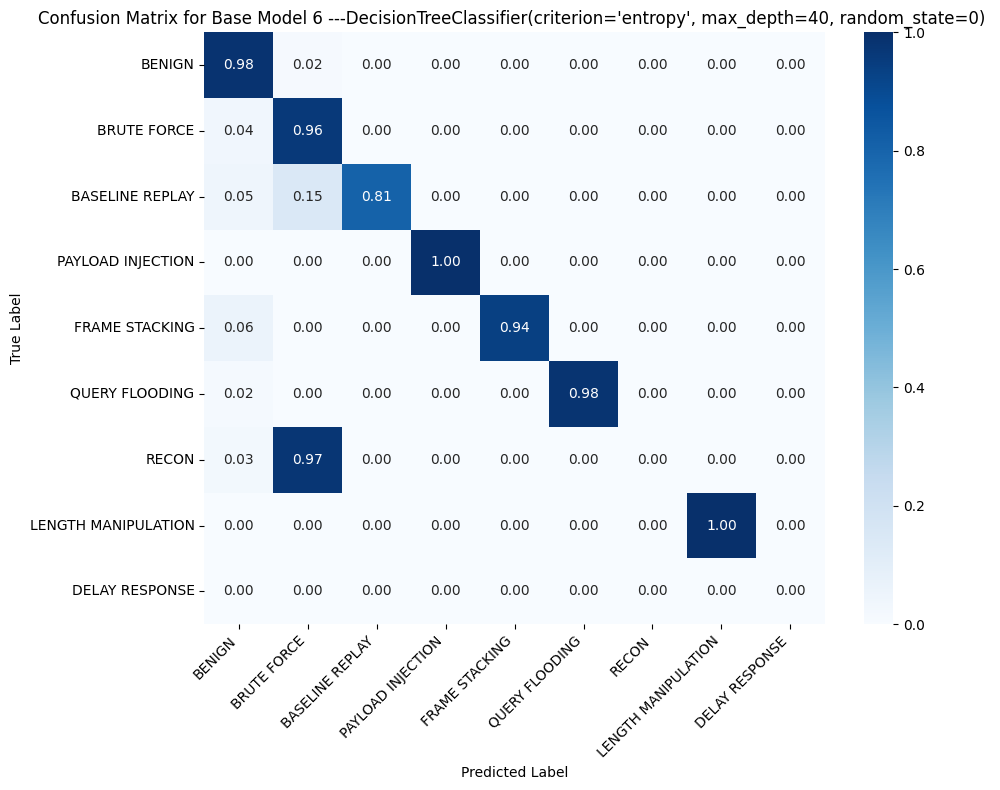


--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=4)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=4) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=4)  0.9814
                     precision    recall  f1-score   support

             BENIGN       0.99      0.98      0.99    132299
        BRUTE FORCE       0.96      0.98      0.97     54785
    BASELINE REPLAY       0.80      0.14      0.23        88
  PAYLOAD INJECTION       0.94      0.58      0.72        55
     FRAME STACKING       0.92      0.88      0.90        67
     QUERY FLOODING       0.91      0.88      0.89        58
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION       1.00      0.91      0.95        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0.93      0.67      0.71    187445
       weighted avg       0.98      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(max_iter=40, random_state=0)  0.9833
                     precision    recall  f1-score   support

             BENIGN       1.00      0.98      0.99    132299
        BRUTE FORCE       0.96      0.99      0.97     54785
    BASELINE REPLAY       0.29      0.74      0.42        88
  PAYLOAD INJECTION       0.09      0.93      0.16        55
     FRAME STACKING       0.82      0.94      0.88        67
     QUERY FLOODING       0.57      0.97      0.72        58
              RECON       0.00      0.00      0.00        40
LENGTH MANIPULATION       0.96      1.00      0.98        53
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [77]:
### Train on the original data distribution (without scale,sampling techniques and drop zero variance columns)
train_evaluate(base_models,X_train,X_val,y_train,y_val,train_dataset.label_encoder)

#### standard scaler


In [81]:
loaded_scalers = load_scalers("fitted_scalers")

# Initialize datasets without scale
train_dataset = ModbusFlowStream(
    csv_files=csv_files2,chunk_size=1,scalers=loaded_scalers["network-wide"]["standard_scalers"]
)
train_dataloader =DataLoader(train_dataset, batch_size=1, shuffle=False)
X , y = np_from_dataloader(train_dataloader)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = val_ratio, random_state = 0,shuffle=shuffle)


Successfully loaded scalers for 'network-wide'


train_dataset unbalanced label distribution before sampling
Label 0: 397046 
Label 1: 164222 
Label 2: 240 
Label 3: 179 
Label 4: 179 
Label 5: 183 
Label 6: 130 
Label 7: 155 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 132411 
Label 1: 54662 
Label 2: 77 
Label 3: 57 
Label 4: 64 
Label 5: 57 
Label 6: 40 
Label 7: 77 
------------------------------

--- Training Base Model 1 ---LogisticRegression(max_iter=40, random_state=0)


/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Evaluating Base Model 1 ---LogisticRegression(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=40, random_state=0)  0.9487
                     precision    recall  f1-score   support

             BENIGN       0.95      0.99      0.96    132411
        BRUTE FORCE       0.96      0.86      0.91     54662
    BASELINE REPLAY       0.00      0.00      0.00        77
  PAYLOAD INJECTION        nan      0.00      0.00        57
     FRAME STACKING       0.97      1.00      0.98        64
     QUERY FLOODING       0.98      0.98      0.98        57
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION       0.97      1.00      0.99        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.95    187445
          macro avg       0.81      0.60      0.60    187445
       weighted avg       0.95      0.95      0.95    187445



/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


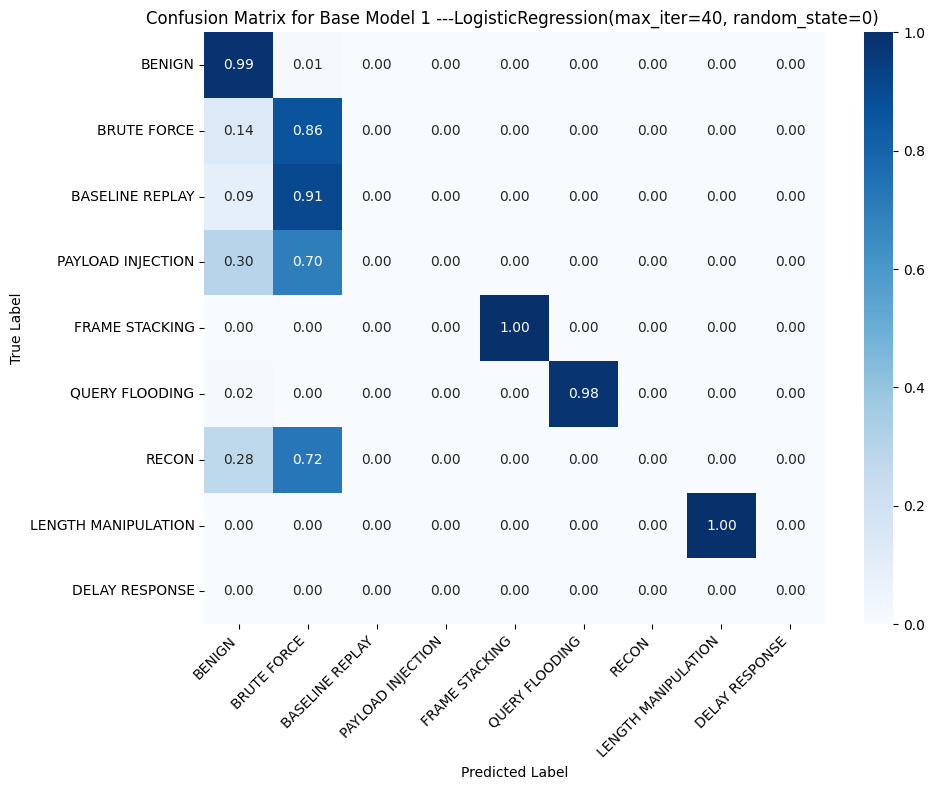


--- Training Base Model 2 ---LinearSVC(max_iter=40, random_state=0)


/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 2 ---LinearSVC(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(max_iter=40, random_state=0)  0.9403
                     precision    recall  f1-score   support

             BENIGN       0.93      0.99      0.96    132411
        BRUTE FORCE       0.96      0.83      0.89     54662
    BASELINE REPLAY        nan      0.00      0.00        77
  PAYLOAD INJECTION        nan      0.00      0.00        57
     FRAME STACKING       0.97      1.00      0.98        64
     QUERY FLOODING       0.98      0.98      0.98        57
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION       1.00      1.00      1.00        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.94    187445
          macro avg       0.97      0.60      0.60    187445
       weighted avg       0.94      0.94      0.94    187445



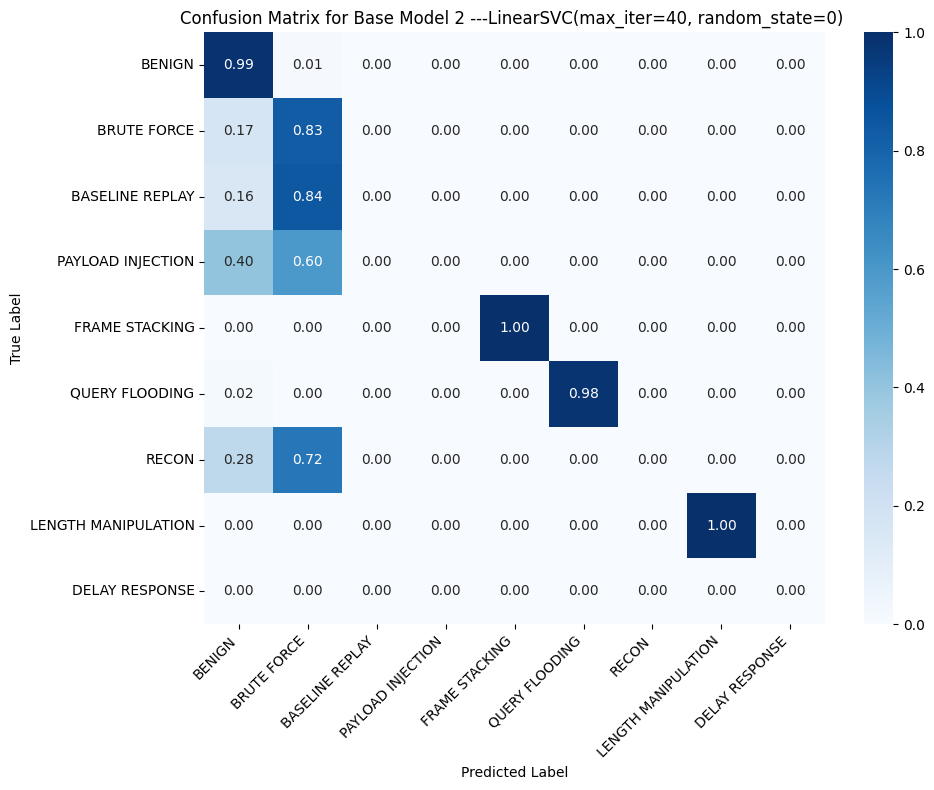


--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.0067
                     precision    recall  f1-score   support

             BENIGN       0.98      0.00      0.00    132411
        BRUTE FORCE       0.70      0.01      0.03     54662
    BASELINE REPLAY       0.00      0.92      0.00        77
  PAYLOAD INJECTION       1.00      1.00      1.00        57
     FRAME STACKING       0.97      1.00      0.98        64
     QUERY FLOODING       0.90      0.98      0.94        57
              RECON       0.00      1.00      0.00        40
LENGTH MANIPULATION       1.00      1.00      1.00        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.01    187445
          macro avg       0.69      0.74      0.49    187445
       weighted avg       0.90      0.01      0.01    187445



/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


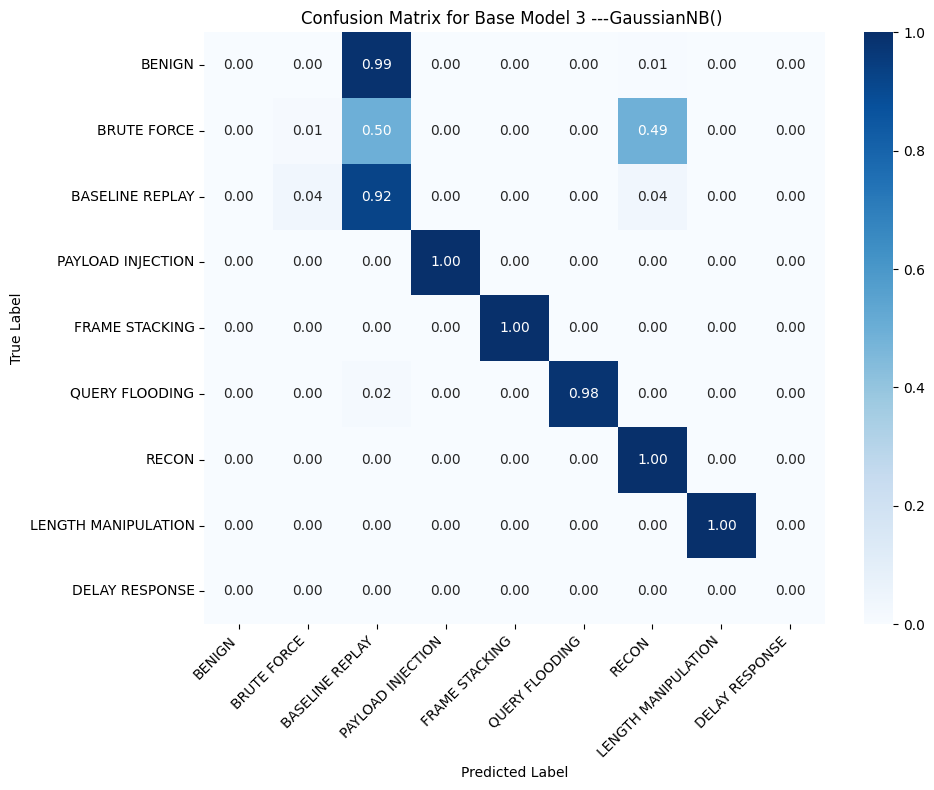


--- Training Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)  0.9875
                     precision    recall  f1-score   support

             BENIGN       1.00      0.98      0.99    132411
        BRUTE FORCE       0.96      1.00      0.98     54662
    BASELINE REPLAY       0.87      0.75      0.81        77
  PAYLOAD INJECTION       1.00      1.00      1.00        57
     FRAME STACKING       0.97      0.98      0.98        64
     QUERY FLOODING       0.98      0.98      0.98        57
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION       1.00      1.00      1.00        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.99    1874

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(max_depth=40, random_state=0)  0.9770
                     precision    recall  f1-score   support

             BENIGN       0.98      0.98      0.98    132411
        BRUTE FORCE       0.96      0.96      0.96     54662
    BASELINE REPLAY       0.66      0.68      0.67        77
  PAYLOAD INJECTION       1.00      1.00      1.00        57
     FRAME STACKING       0.97      0.98      0.98        64
     QUERY FLOODING       0.97      0.98      0.97        57
              RECON       0.02      0.03      0.02        40
LENGTH MANIPULATION       0.99      1.00      0.99        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0.82      0.83      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)  0.9785
                     precision    recall  f1-score   support

             BENIGN       0.99      0.98      0.99    132411
        BRUTE FORCE       0.96      0.96      0.96     54662
    BASELINE REPLAY       0.76      0.84      0.80        77
  PAYLOAD INJECTION       1.00      1.00      1.00        57
     FRAME STACKING       0.94      0.98      0.96        64
     QUERY FLOODING       0.98      0.98      0.98        57
              RECON       0.04      0.05      0.05        40
LENGTH MANIPULATION       1.00      1.00      1.00        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


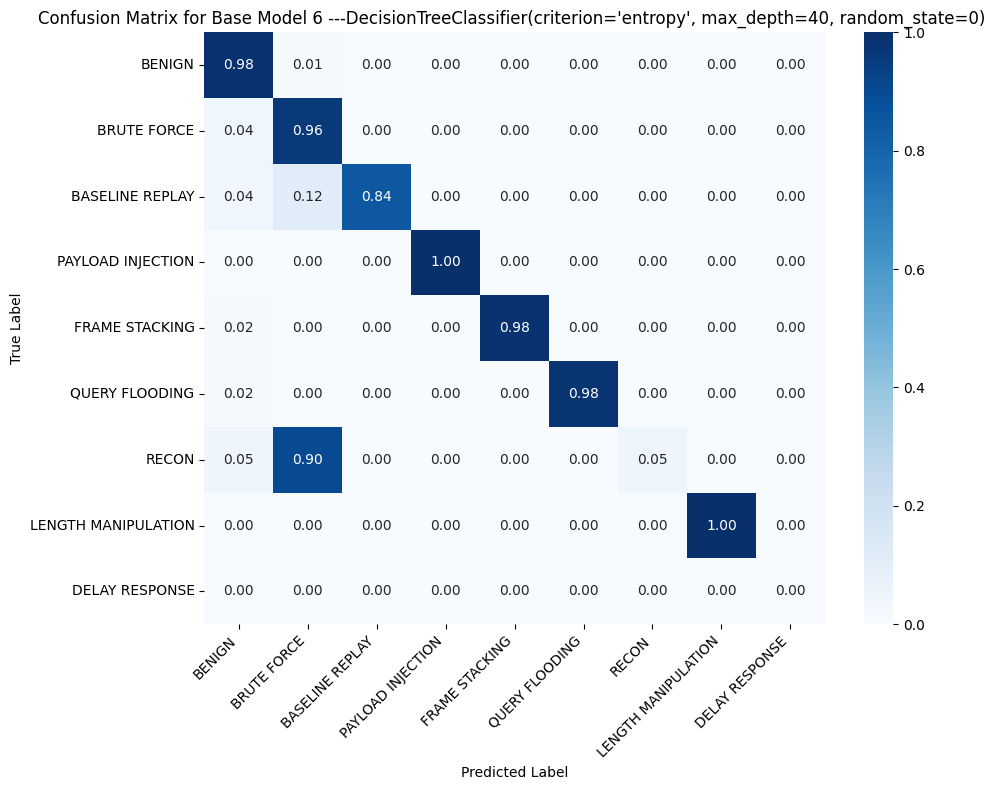


--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=4)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=4) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=4)  0.9825
                     precision    recall  f1-score   support

             BENIGN       0.99      0.98      0.99    132411
        BRUTE FORCE       0.96      0.98      0.97     54662
    BASELINE REPLAY       0.85      0.73      0.78        77
  PAYLOAD INJECTION       1.00      0.93      0.96        57
     FRAME STACKING       0.96      1.00      0.98        64
     QUERY FLOODING       0.98      0.96      0.97        57
              RECON        nan      0.00      0.00        40
LENGTH MANIPULATION       1.00      1.00      1.00        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0.96      0.82      0.83    187445
       weighted avg       0.98      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


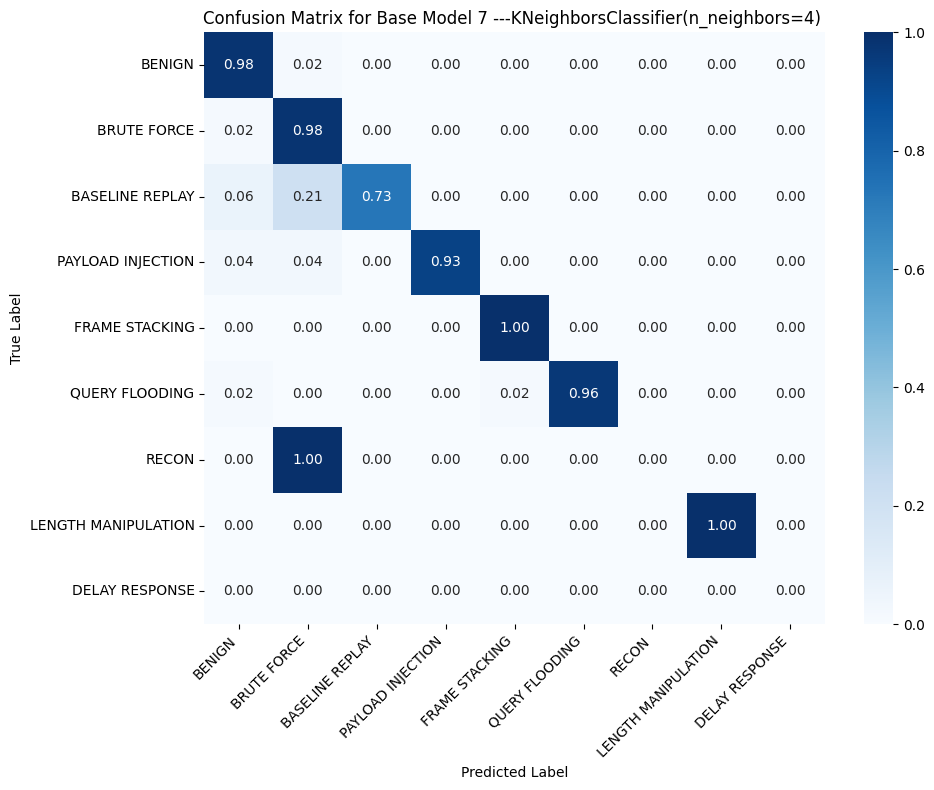


--- Training Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(max_iter=40, random_state=0)  0.9843
                     precision    recall  f1-score   support

             BENIGN       1.00      0.98      0.99    132411
        BRUTE FORCE       0.96      0.99      0.98     54662
    BASELINE REPLAY       0.51      0.90      0.65        77
  PAYLOAD INJECTION       0.74      1.00      0.85        57
     FRAME STACKING       0.51      0.81      0.63        64
     QUERY FLOODING       0.79      0.86      0.82        57
              RECON       0.00      0.03      0.00        40
LENGTH MANIPULATION       0.64      1.00      0.78        77
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


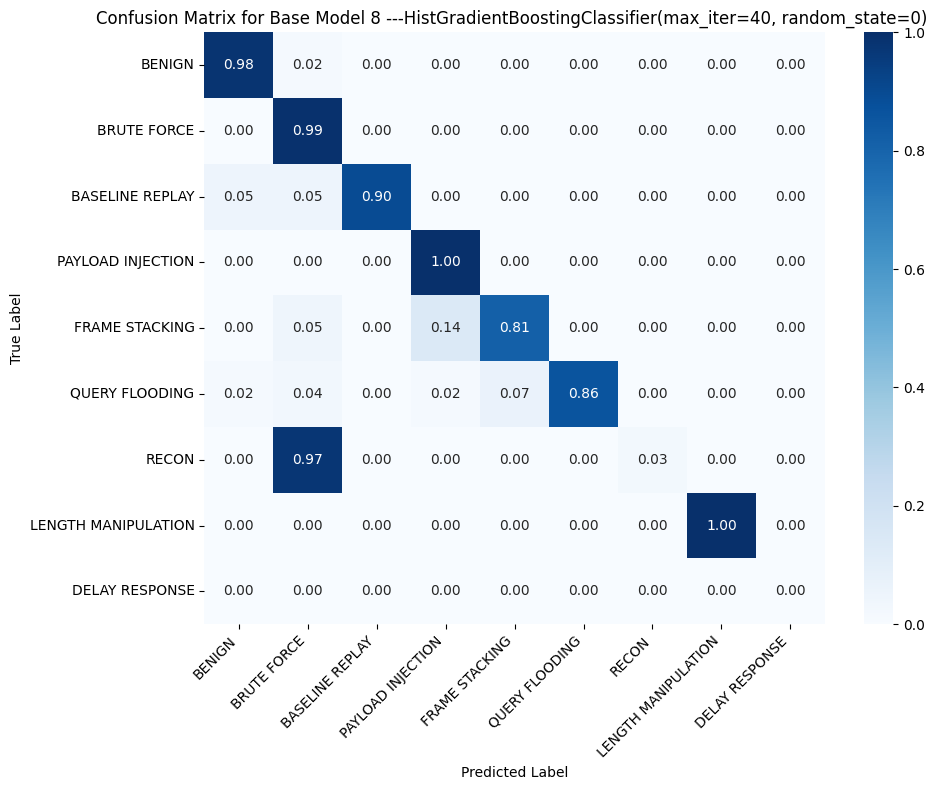

In [82]:
### try with standard scale
train_evaluate(base_models,X_train,X_val,y_train,y_val,train_dataset.label_encoder)

### minmax scaler

train_dataset unbalanced label distribution before sampling
Label 0: 397013 
Label 1: 164244 
Label 2: 231 
Label 3: 161 
Label 4: 182 
Label 5: 188 
Label 6: 138 
Label 7: 177 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 132444 
Label 1: 54640 
Label 2: 86 
Label 3: 75 
Label 4: 61 
Label 5: 52 
Label 6: 32 
Label 7: 55 
------------------------------

--- Training Base Model 1 ---LogisticRegression(max_iter=40, random_state=0)


/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Evaluating Base Model 1 ---LogisticRegression(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=40, random_state=0)  0.9483
                     precision    recall  f1-score   support

             BENIGN       0.95      0.99      0.97    132444
        BRUTE FORCE       0.96      0.86      0.91     54640
    BASELINE REPLAY        nan      0.00      0.00        86
  PAYLOAD INJECTION        nan      0.00      0.00        75
     FRAME STACKING        nan      0.00      0.00        61
     QUERY FLOODING       1.00      0.08      0.14        52
              RECON        nan      0.00      0.00        32
LENGTH MANIPULATION        nan      0.00      0.00        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.95    187445
          macro avg       0.97      0.24      0.25    187445
       weighted avg       0.95      0.95      0.95    187445



/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


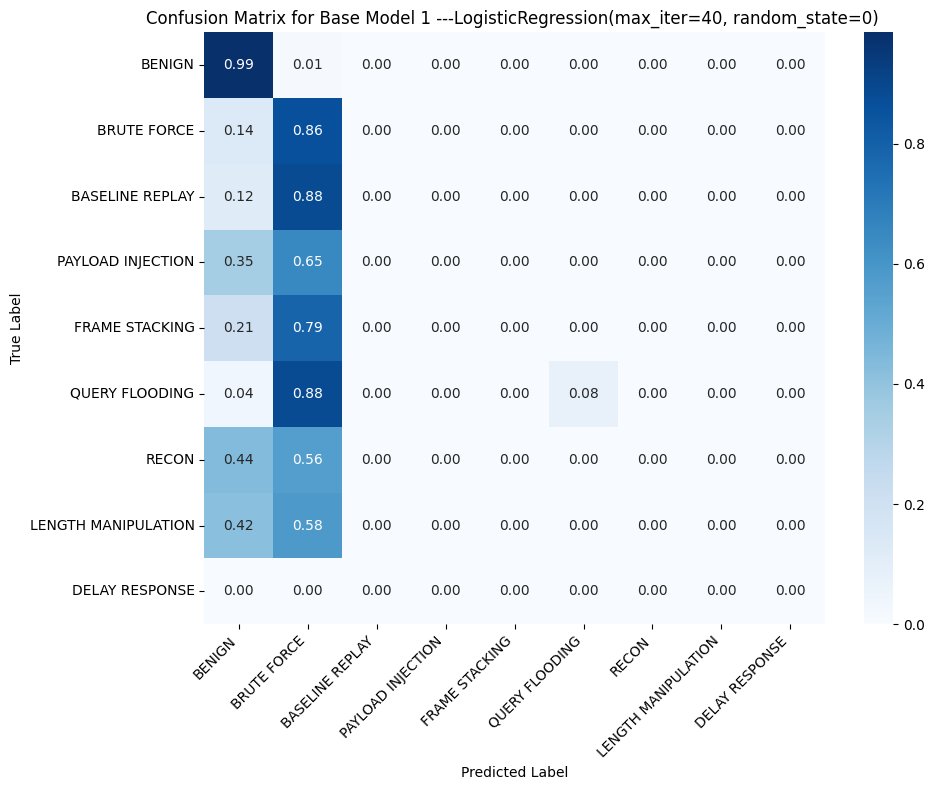


--- Training Base Model 2 ---LinearSVC(max_iter=40, random_state=0)


/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 2 ---LinearSVC(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(max_iter=40, random_state=0)  0.9399
                     precision    recall  f1-score   support

             BENIGN       0.93      0.99      0.96    132444
        BRUTE FORCE       0.96      0.83      0.89     54640
    BASELINE REPLAY        nan      0.00      0.00        86
  PAYLOAD INJECTION        nan      0.00      0.00        75
     FRAME STACKING       1.00      0.85      0.92        61
     QUERY FLOODING       0.98      1.00      0.99        52
              RECON        nan      0.00      0.00        32
LENGTH MANIPULATION       0.98      0.87      0.92        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.94    187445
          macro avg       0.97      0.57      0.59    187445
       weighted avg       0.94      0.94      0.94    187445



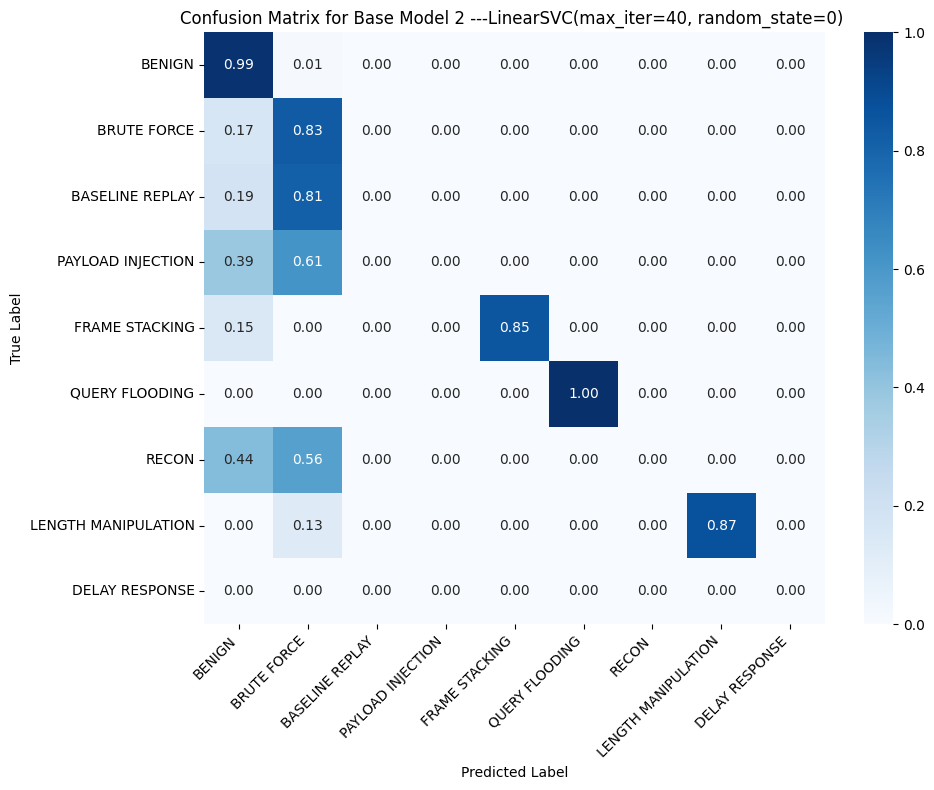


--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.0060
                     precision    recall  f1-score   support

             BENIGN       1.00      0.00      0.00    132444
        BRUTE FORCE       0.74      0.01      0.02     54640
    BASELINE REPLAY       0.00      0.87      0.00        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      1.00      0.99        61
     QUERY FLOODING       0.91      1.00      0.95        52
              RECON       0.00      0.97      0.00        32
LENGTH MANIPULATION       0.98      0.98      0.98        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.01    187445
          macro avg       0.70      0.73      0.49    187445
       weighted avg       0.92      0.01      0.01    187445



/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


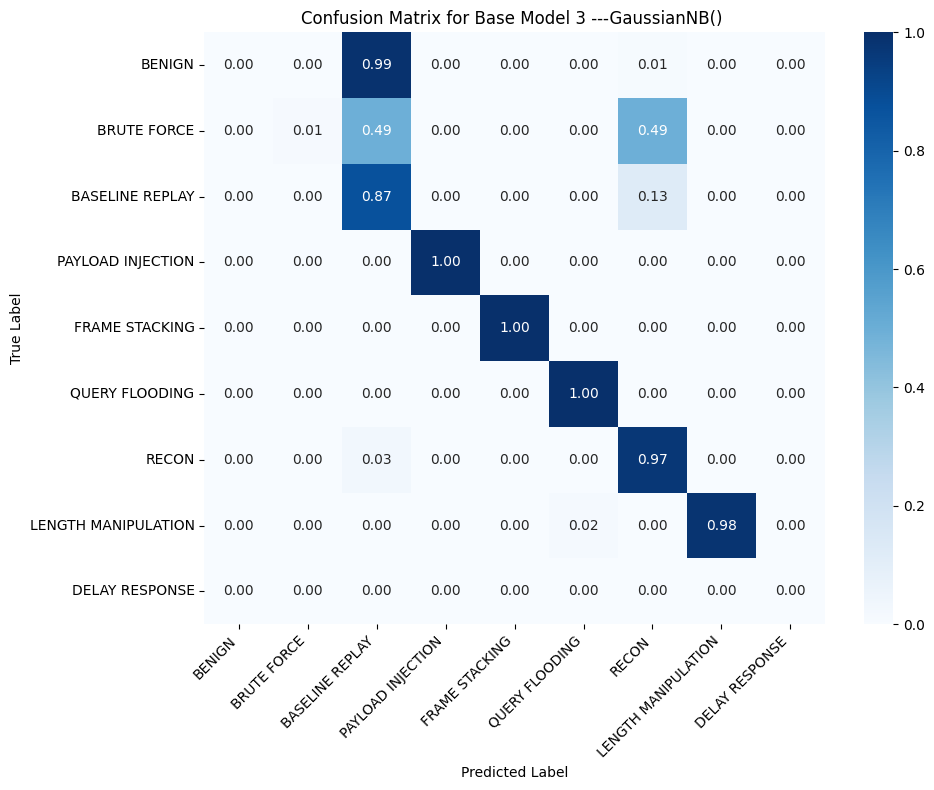


--- Training Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)  0.9872
                     precision    recall  f1-score   support

             BENIGN       1.00      0.98      0.99    132444
        BRUTE FORCE       0.96      1.00      0.98     54640
    BASELINE REPLAY       0.88      0.77      0.82        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      1.00      0.99        61
     QUERY FLOODING       0.98      1.00      0.99        52
              RECON       0.00      0.00      0.00        32
LENGTH MANIPULATION       0.98      1.00      0.99        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.99    1874

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


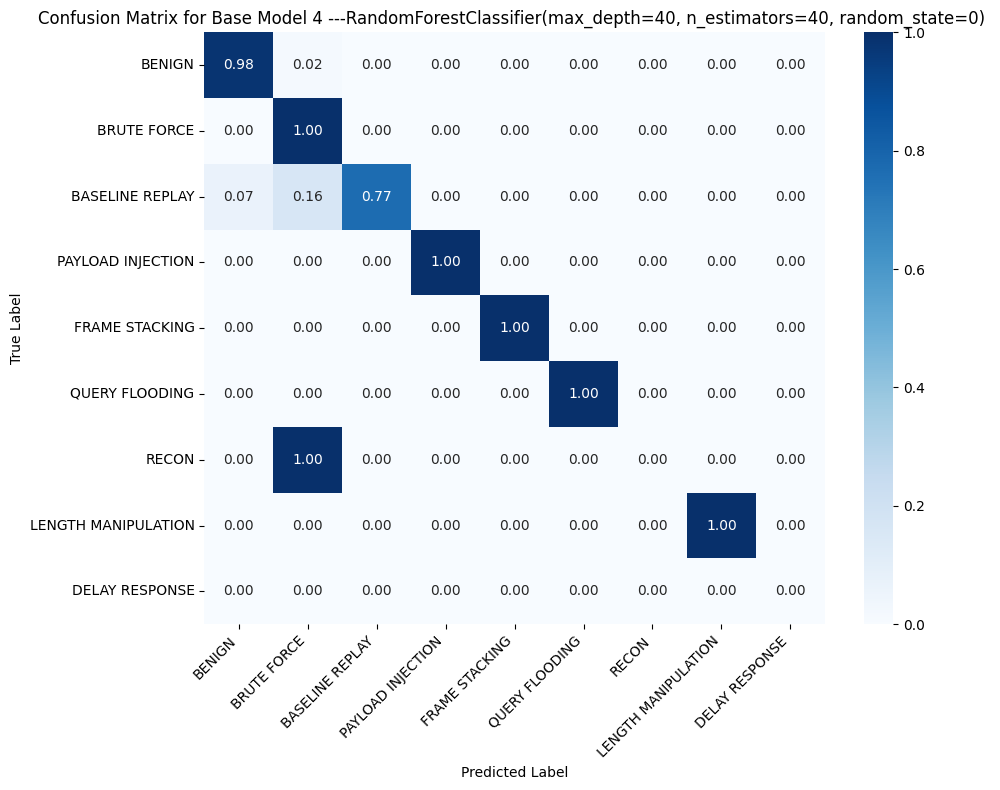


--- Training Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(max_depth=40, random_state=0)  0.9772
                     precision    recall  f1-score   support

             BENIGN       0.98      0.98      0.98    132444
        BRUTE FORCE       0.96      0.96      0.96     54640
    BASELINE REPLAY       0.73      0.62      0.67        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      0.98      0.98        61
     QUERY FLOODING       0.95      1.00      0.97        52
              RECON       0.00      0.00      0.00        32
LENGTH MANIPULATION       0.96      1.00      0.98        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0.82      0.82      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


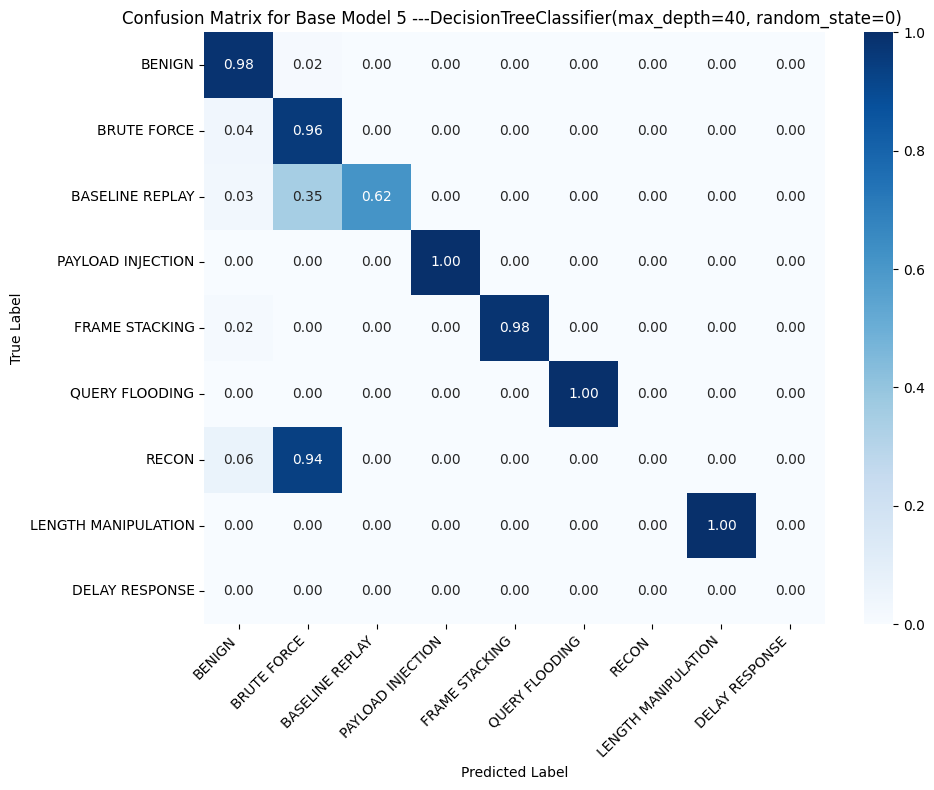


--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)  0.9780
                     precision    recall  f1-score   support

             BENIGN       0.99      0.98      0.98    132444
        BRUTE FORCE       0.96      0.96      0.96     54640
    BASELINE REPLAY       0.80      0.77      0.79        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      0.98      0.98        61
     QUERY FLOODING       0.95      1.00      0.97        52
              RECON       0.00      0.00      0.00        32
LENGTH MANIPULATION       0.96      1.00      0.98        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


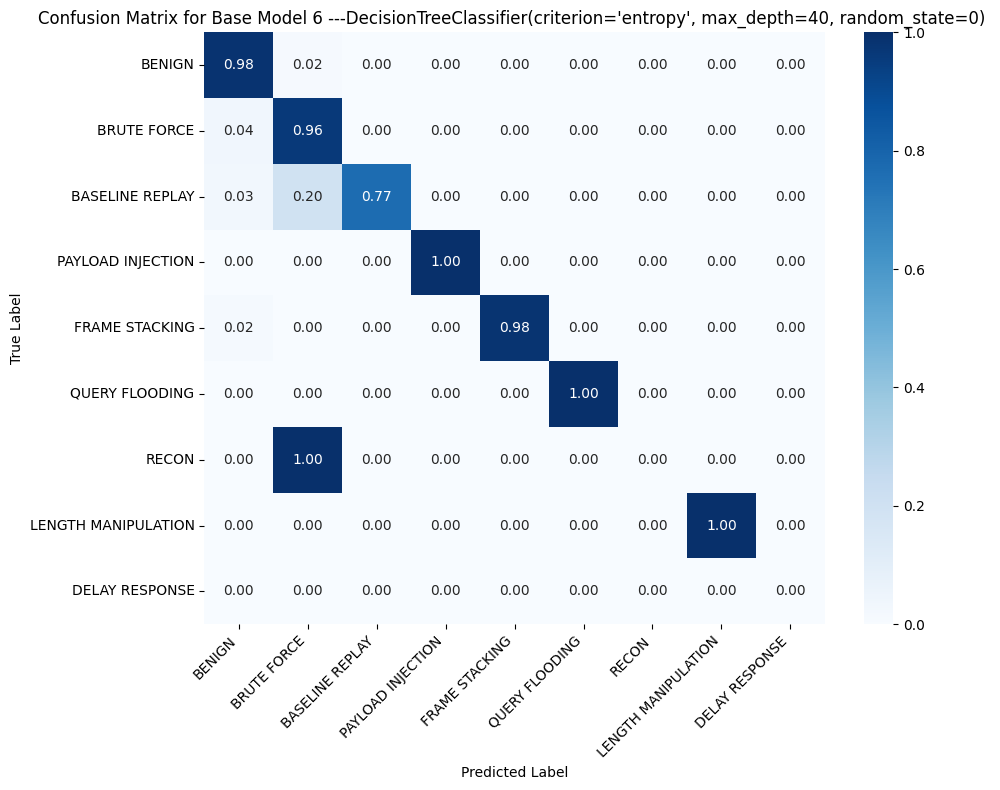


--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=4)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=4) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=4)  0.9825
                     precision    recall  f1-score   support

             BENIGN       0.99      0.98      0.99    132444
        BRUTE FORCE       0.96      0.99      0.97     54640
    BASELINE REPLAY       0.89      0.63      0.73        86
  PAYLOAD INJECTION       0.99      0.96      0.97        75
     FRAME STACKING       0.98      0.98      0.98        61
     QUERY FLOODING       0.98      1.00      0.99        52
              RECON        nan      0.00      0.00        32
LENGTH MANIPULATION       0.98      1.00      0.99        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.98    187445
          macro avg       0.97      0.82      0.83    187445
       weighted avg       0.98      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


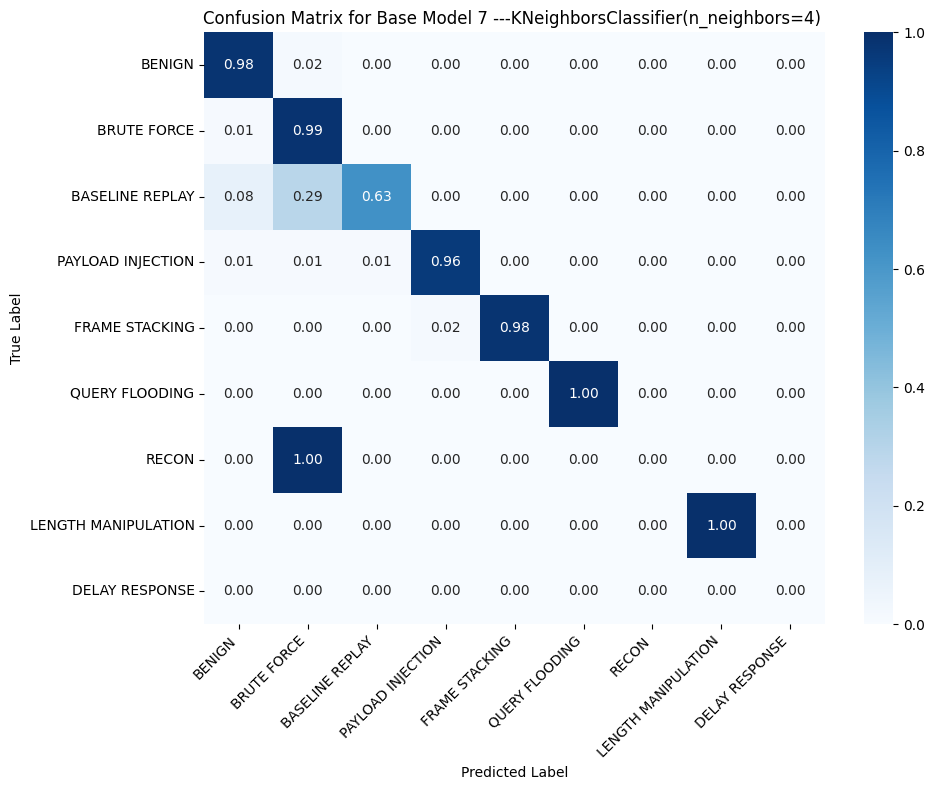


--- Training Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(max_iter=40, random_state=0)  0.9857
                     precision    recall  f1-score   support

             BENIGN       1.00      0.98      0.99    132444
        BRUTE FORCE       0.96      0.99      0.98     54640
    BASELINE REPLAY       0.71      0.70      0.70        86
  PAYLOAD INJECTION       0.66      1.00      0.80        75
     FRAME STACKING       0.95      0.90      0.92        61
     QUERY FLOODING       0.63      0.96      0.76        52
              RECON       0.01      0.03      0.01        32
LENGTH MANIPULATION       0.40      0.82      0.54        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.99    187445
          macro avg       0

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


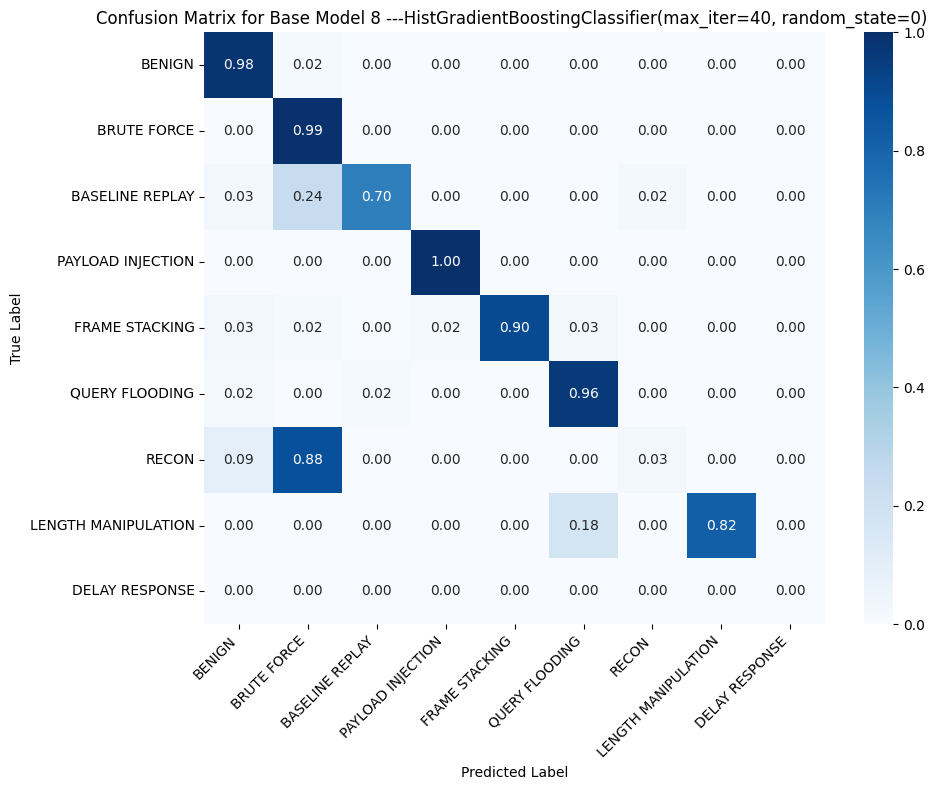

In [83]:
# Initialize datasets without scale
train_dataset = ModbusFlowStream(
    csv_files=csv_files2,chunk_size=1,scalers=loaded_scalers["network-wide"]["min_max_scalers"]
)
train_dataloader =DataLoader(train_dataset, batch_size=1, shuffle=False)
X , y = np_from_dataloader(train_dataloader)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = val_ratio, random_state = 0,shuffle=shuffle)
train_evaluate(base_models,X_train,X_val,y_train,y_val,train_dataset.label_encoder)

#### Downsampling

In [84]:

sampling_strategy_rus = {
    0: 200,  
    1: 200, 
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_rus, random_state=42)

X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
print("\nDistribution after RandomUnderSampler:")
print(dict(Counter(y_resampled_rus)))
print(f"Resampled X_train shape (RUS): {X_resampled_rus.shape}")
print(f"Resampled y_train shape (RUS): {y_resampled_rus.shape}")
print("-" * 50)



Distribution after RandomUnderSampler:
{0: 200, 1: 200, 2: 231, 3: 161, 4: 182, 5: 188, 6: 138, 7: 177}
Resampled X_train shape (RUS): (1477, 76)
Resampled y_train shape (RUS): (1477,)
--------------------------------------------------


train_dataset unbalanced label distribution before sampling
Label 0: 200 
Label 1: 200 
Label 2: 231 
Label 3: 161 
Label 4: 182 
Label 5: 188 
Label 6: 138 
Label 7: 177 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 132444 
Label 1: 54640 
Label 2: 86 
Label 3: 75 
Label 4: 61 
Label 5: 52 
Label 6: 32 
Label 7: 55 
------------------------------

--- Training Base Model 1 ---LogisticRegression(max_iter=40, random_state=0)
--- Evaluating Base Model 1 ---LogisticRegression(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=40, random_state=0)  0.7175


/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


                     precision    recall  f1-score   support

             BENIGN       0.93      0.98      0.96    132444
        BRUTE FORCE       0.97      0.07      0.13     54640
    BASELINE REPLAY       0.00      0.71      0.00        86
  PAYLOAD INJECTION        nan      0.00      0.00        75
     FRAME STACKING       1.00      0.84      0.91        61
     QUERY FLOODING       0.35      1.00      0.52        52
              RECON        nan      0.00      0.00        32
LENGTH MANIPULATION       0.08      1.00      0.15        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.72    187445
          macro avg       0.56      0.58      0.33    187445
       weighted avg       0.94      0.72      0.71    187445



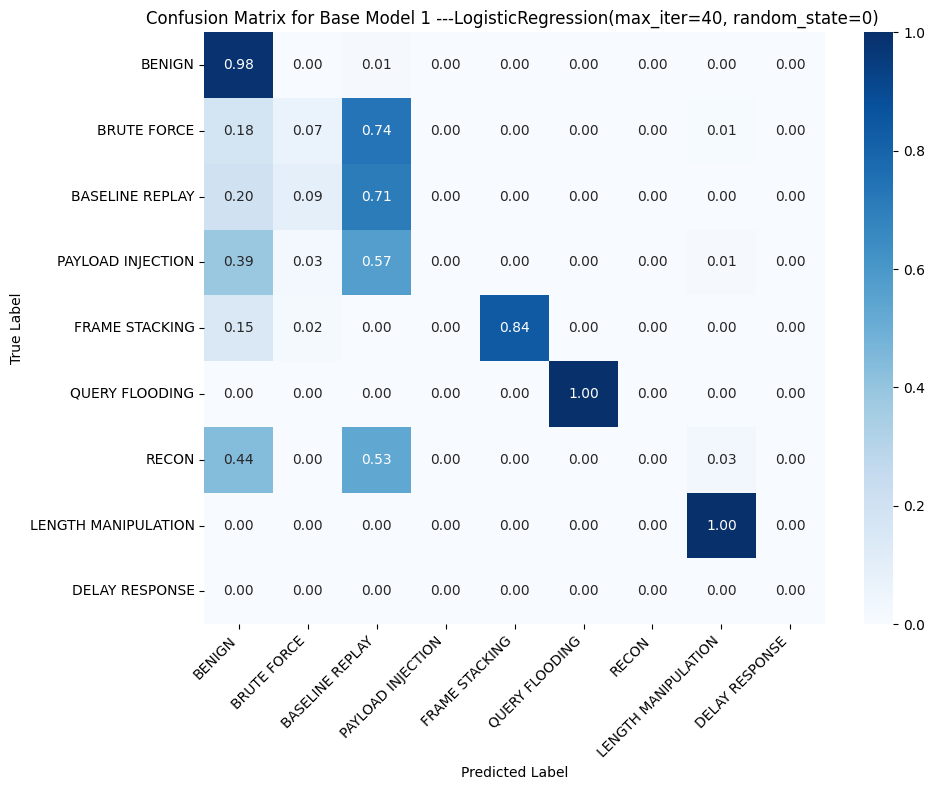


--- Training Base Model 2 ---LinearSVC(max_iter=40, random_state=0)
--- Evaluating Base Model 2 ---LinearSVC(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(max_iter=40, random_state=0)  0.7175
                     precision    recall  f1-score   support

             BENIGN       0.93      0.98      0.96    132444
        BRUTE FORCE       0.97      0.07      0.13     54640
    BASELINE REPLAY       0.00      0.71      0.00        86
  PAYLOAD INJECTION       0.00      0.00      0.00        75
     FRAME STACKING       0.39      0.98      0.56        61
     QUERY FLOODING       0.98      1.00      0.99        52
              RECON        nan      0.00      0.00        32
LENGTH MANIPULATION       0.08      1.00      0.15        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.72    187445
          macro avg       0.48      0.59      0.35    187445
       weighted avg       0.9

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


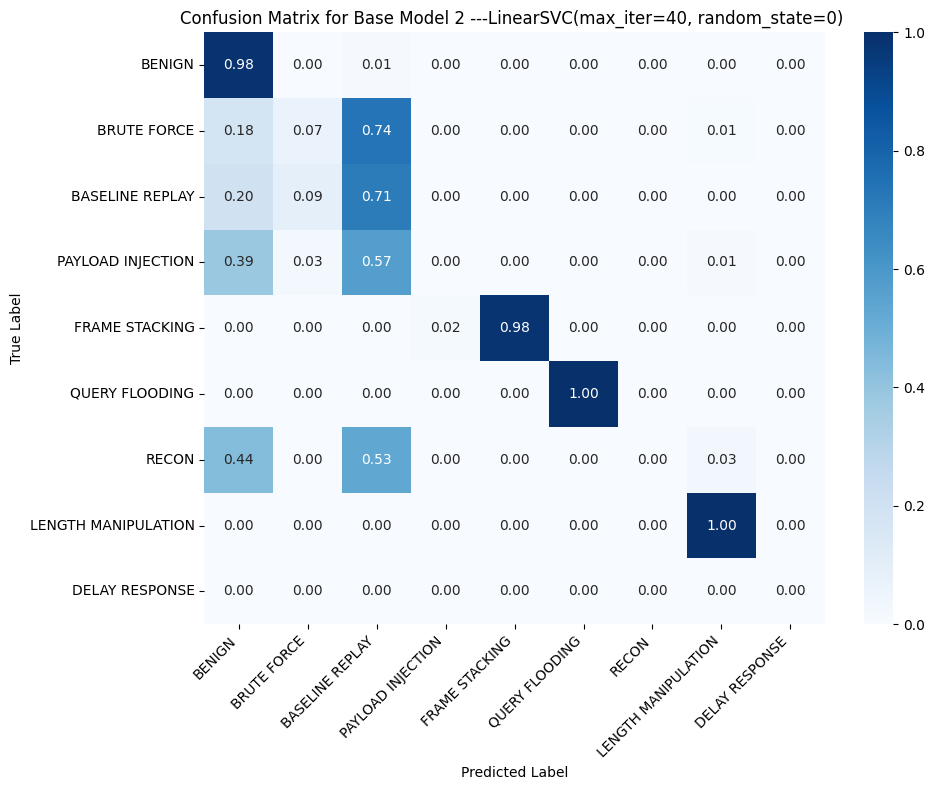


--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.6992
                     precision    recall  f1-score   support

             BENIGN       0.93      0.98      0.96    132444
        BRUTE FORCE       0.65      0.01      0.03     54640
    BASELINE REPLAY       0.00      0.70      0.01        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      1.00      0.99        61
     QUERY FLOODING       0.91      1.00      0.95        52
              RECON       0.00      0.69      0.00        32
LENGTH MANIPULATION       0.98      0.98      0.98        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.70    187445
          macro avg       0.68      0.80      0.61    187445
       weighted avg       0.85      0.70      0.68    187445



/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


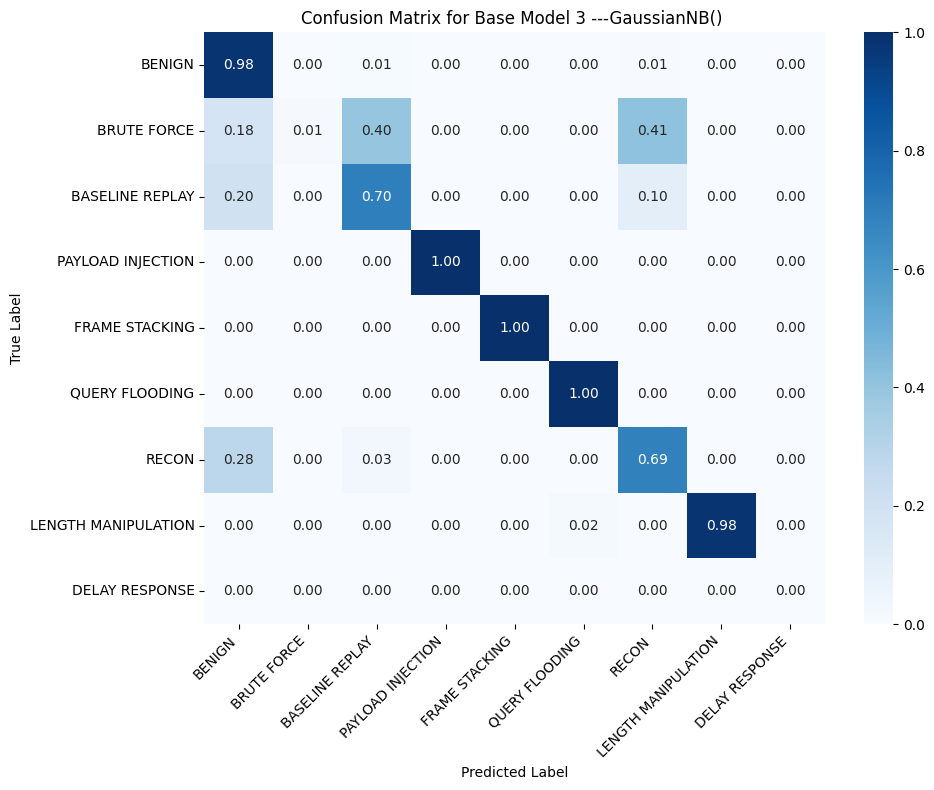


--- Training Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)  0.9209
                     precision    recall  f1-score   support

             BENIGN       1.00      0.97      0.99    132444
        BRUTE FORCE       0.95      0.79      0.87     54640
    BASELINE REPLAY       0.06      0.87      0.11        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      1.00      0.99        61
     QUERY FLOODING       0.50      1.00      0.67        52
              RECON       0.00      0.69      0.00        32
LENGTH MANIPULATION       0.30      1.00      0.46        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.92    1874

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


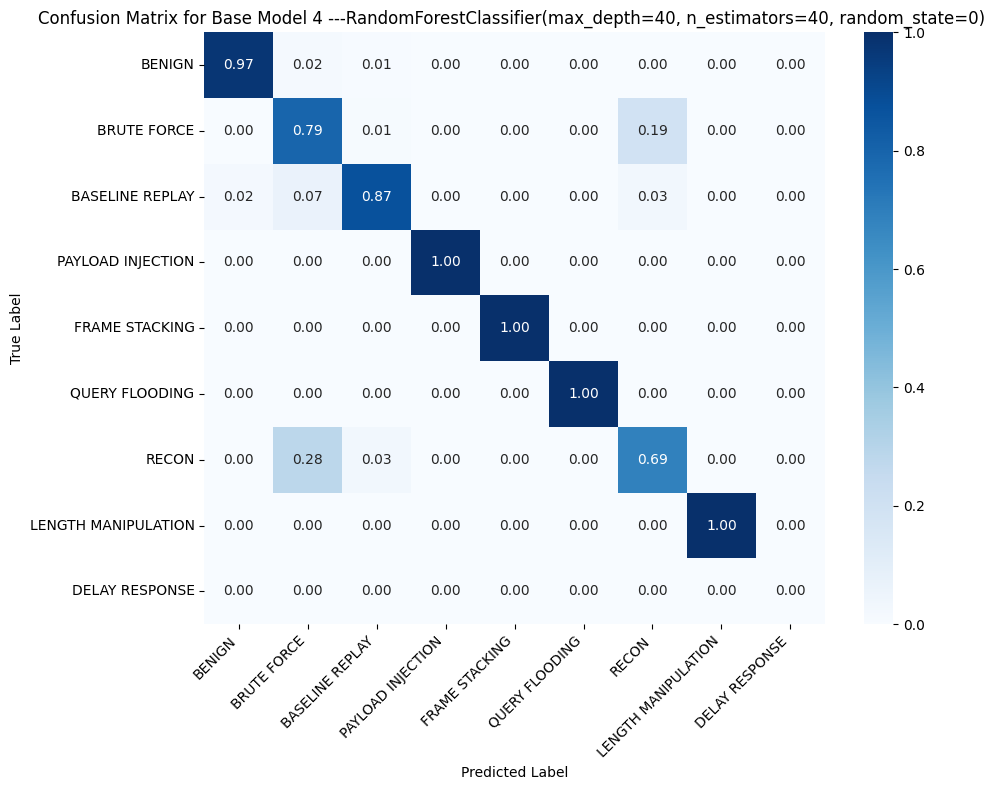


--- Training Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(max_depth=40, random_state=0)  0.9055
                     precision    recall  f1-score   support

             BENIGN       1.00      0.95      0.97    132444
        BRUTE FORCE       0.96      0.79      0.87     54640
    BASELINE REPLAY       0.02      0.86      0.04        86
  PAYLOAD INJECTION       0.96      1.00      0.98        75
     FRAME STACKING       0.39      1.00      0.56        61
     QUERY FLOODING       0.04      1.00      0.07        52
              RECON       0.00      0.69      0.00        32
LENGTH MANIPULATION       0.14      1.00      0.25        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.91    187445
          macro avg       0.44      0.91      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


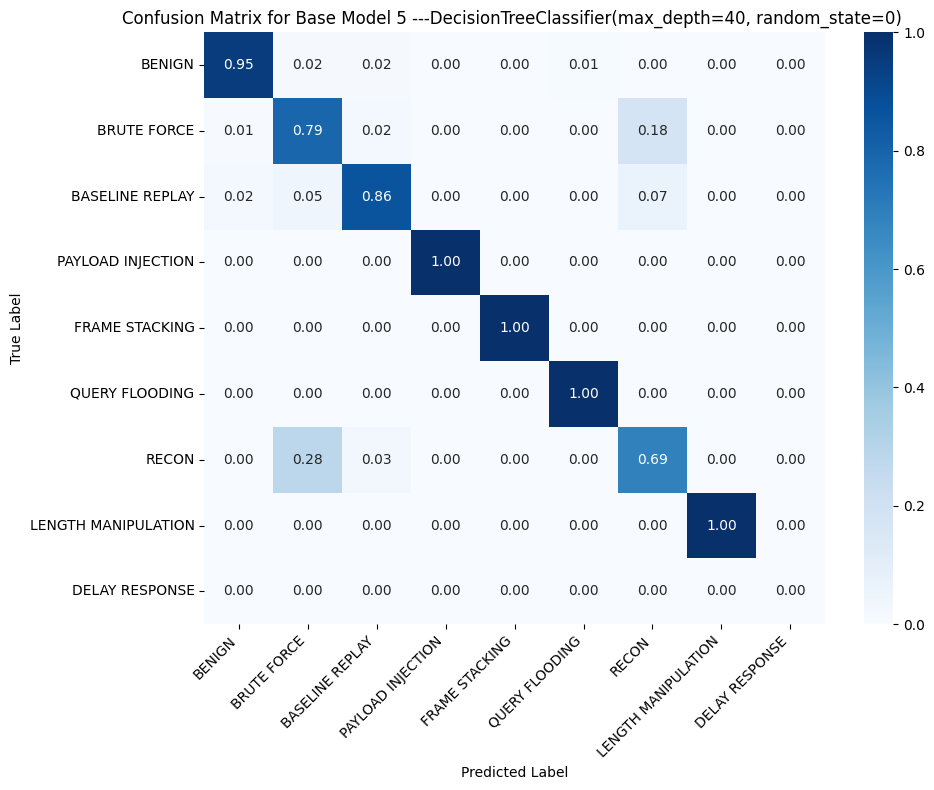


--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)  0.8921
                     precision    recall  f1-score   support

             BENIGN       1.00      0.94      0.97    132444
        BRUTE FORCE       0.96      0.78      0.86     54640
    BASELINE REPLAY       0.02      0.87      0.05        86
  PAYLOAD INJECTION       0.44      1.00      0.61        75
     FRAME STACKING       0.97      1.00      0.98        61
     QUERY FLOODING       0.01      1.00      0.03        52
              RECON       0.00      0.75      0.00        32
LENGTH MANIPULATION       0.13      1.00      0.23        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


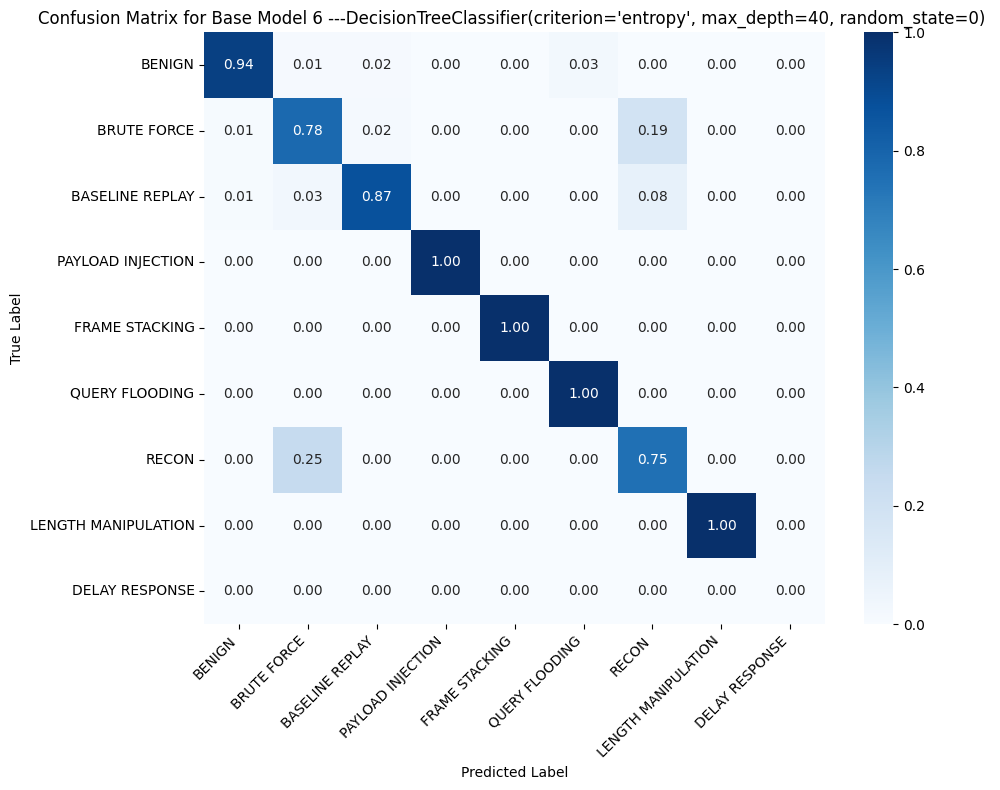


--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=4)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=4) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=4)  0.9146
                     precision    recall  f1-score   support

             BENIGN       0.99      0.98      0.98    132444
        BRUTE FORCE       0.96      0.76      0.85     54640
    BASELINE REPLAY       0.02      0.77      0.05        86
  PAYLOAD INJECTION       0.22      0.97      0.36        75
     FRAME STACKING       0.98      0.98      0.98        61
     QUERY FLOODING       0.98      1.00      0.99        52
              RECON       0.00      0.62      0.00        32
LENGTH MANIPULATION       0.32      1.00      0.48        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.91    187445
          macro avg       0.56      0.89      0.59    187445
       weighted avg       0.98      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


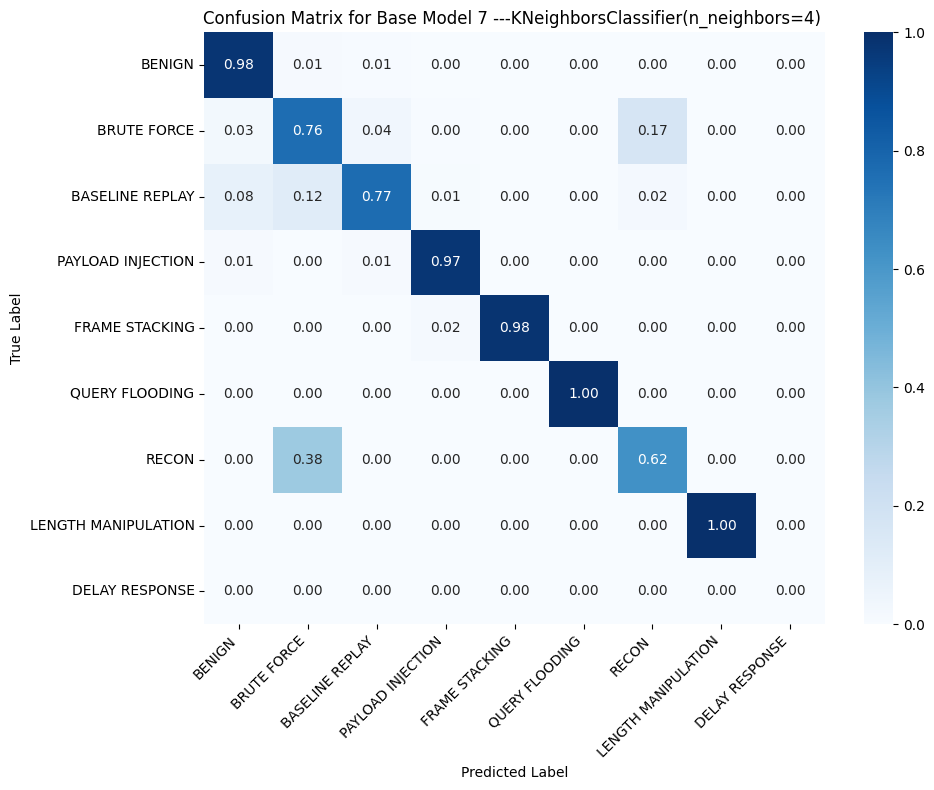


--- Training Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(max_iter=40, random_state=0)  0.9281
                     precision    recall  f1-score   support

             BENIGN       1.00      0.97      0.99    132444
        BRUTE FORCE       0.96      0.82      0.88     54640
    BASELINE REPLAY       0.05      0.88      0.10        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.97      1.00      0.98        61
     QUERY FLOODING       0.21      1.00      0.35        52
              RECON       0.00      0.88      0.01        32
LENGTH MANIPULATION       0.30      1.00      0.46        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.93    187445
          macro avg       0

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [85]:

### Train on the balanced distribution
train_evaluate(base_models,X_resampled_rus,X_val,y_resampled_rus,y_val,train_dataset.label_encoder)

In [86]:

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X_resampled_rus, y_resampled_rus)

print("\nDistribution after SMOTE OverSampler:")
print(dict(Counter(y_upsampled)))
print(f"Resampled X_train shape (RUS): {X_upsampled.shape}")
print(f"Resampled y_train shape (RUS): {y_upsampled.shape}")
print("-" * 50)




Distribution after SMOTE OverSampler:
{0: 231, 1: 231, 2: 231, 3: 231, 4: 231, 5: 231, 6: 231, 7: 231}
Resampled X_train shape (RUS): (1848, 76)
Resampled y_train shape (RUS): (1848,)
--------------------------------------------------


train_dataset unbalanced label distribution before sampling
Label 0: 231 
Label 1: 231 
Label 2: 231 
Label 3: 231 
Label 4: 231 
Label 5: 231 
Label 6: 231 
Label 7: 231 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 132444 
Label 1: 54640 
Label 2: 86 
Label 3: 75 
Label 4: 61 
Label 5: 52 
Label 6: 32 
Label 7: 55 
------------------------------

--- Training Base Model 1 ---LogisticRegression(max_iter=40, random_state=0)
--- Evaluating Base Model 1 ---LogisticRegression(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=40, random_state=0)  0.7176
                     precision    recall  f1-score   support

             BENIGN       0.93      0.98      0.96    132444
        BRUTE FORCE       0.97      0.07      0.13     54640
    BASELINE REPLAY       0.00      0.71      0.00        86
  PAYLOAD INJECTION        nan      0.00      0.00        75
     FRAME STACKING      

/home/hamid_rd3/labeling/Project1404/FLBased-ICS-NIDS/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


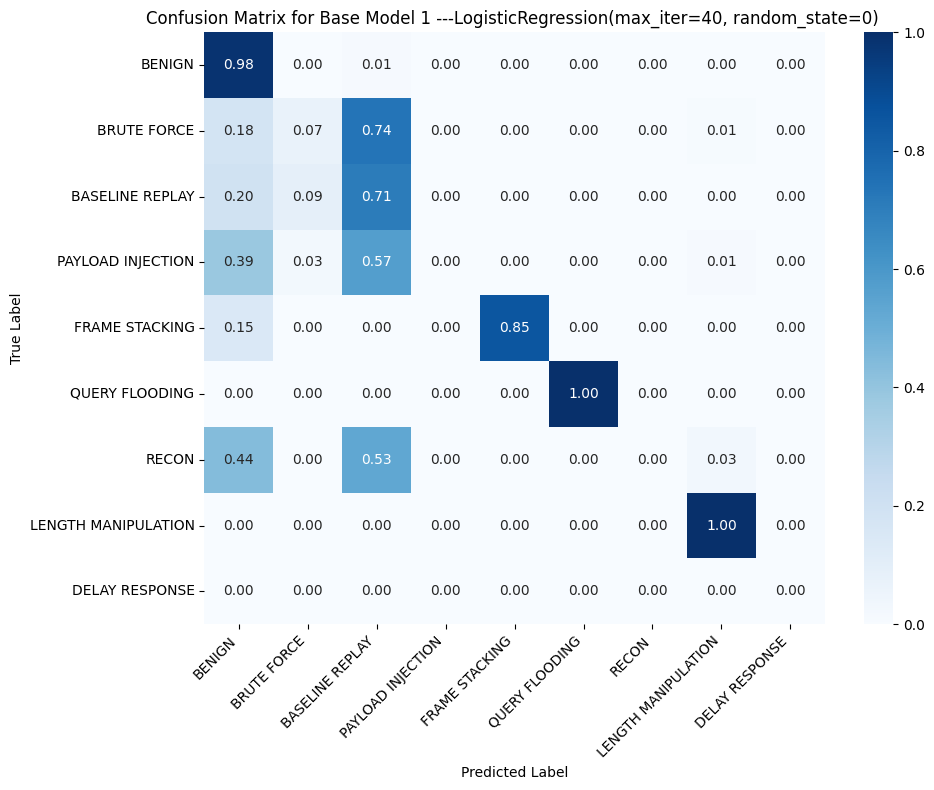


--- Training Base Model 2 ---LinearSVC(max_iter=40, random_state=0)
--- Evaluating Base Model 2 ---LinearSVC(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(max_iter=40, random_state=0)  0.7598
                     precision    recall  f1-score   support

             BENIGN       0.93      0.98      0.96    132444
        BRUTE FORCE       0.97      0.21      0.35     54640
    BASELINE REPLAY       0.00      0.59      0.00        86
  PAYLOAD INJECTION       0.00      0.00      0.00        75
     FRAME STACKING       0.39      0.98      0.56        61
     QUERY FLOODING       0.98      1.00      0.99        52
              RECON       0.00      0.06      0.00        32
LENGTH MANIPULATION       0.08      1.00      0.15        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.76    187445
          macro avg       0.42      0.60      0.38    187445
       weighted avg       0.9

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


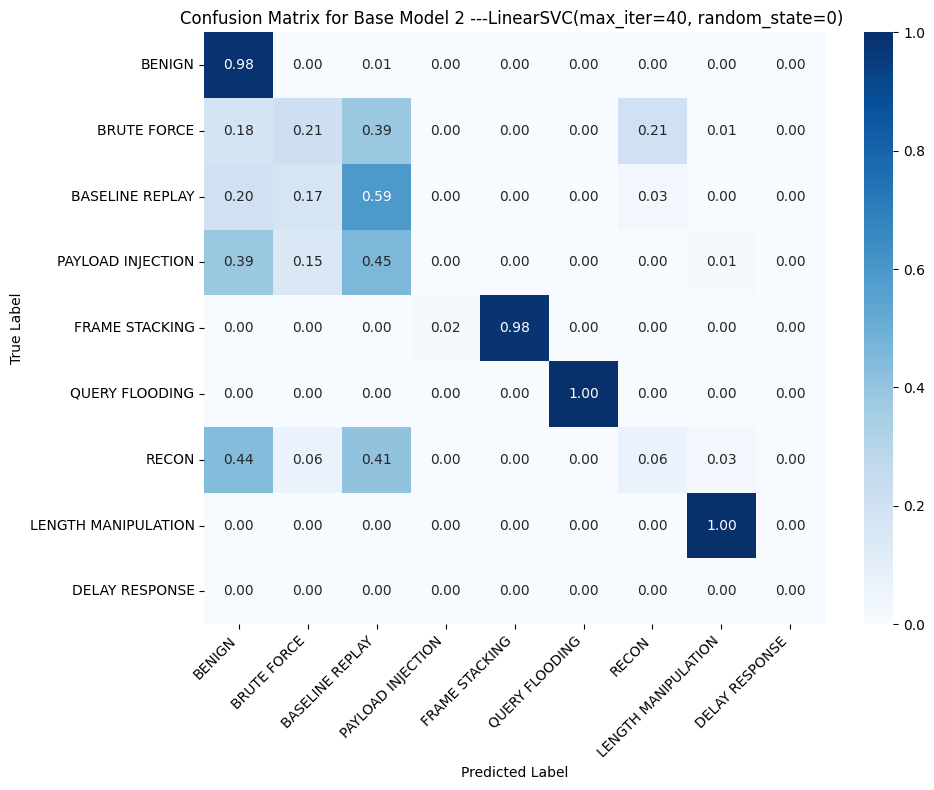


--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.6994
                     precision    recall  f1-score   support

             BENIGN       0.93      0.98      0.96    132444
        BRUTE FORCE       0.66      0.01      0.03     54640
    BASELINE REPLAY       0.00      0.70      0.01        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      1.00      0.99        61
     QUERY FLOODING       0.91      1.00      0.95        52
              RECON       0.00      0.72      0.00        32
LENGTH MANIPULATION       0.98      0.98      0.98        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.70    187445
          macro avg       0.68      0.80      0.61    187445
       weighted avg       0.85      0.70      0.68    187445



/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(max_depth=40, n_estimators=40, random_state=0)  0.9202
                     precision    recall  f1-score   support

             BENIGN       1.00      0.97      0.99    132444
        BRUTE FORCE       0.95      0.79      0.86     54640
    BASELINE REPLAY       0.06      0.87      0.11        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      1.00      0.99        61
     QUERY FLOODING       0.51      1.00      0.68        52
              RECON       0.00      0.78      0.00        32
LENGTH MANIPULATION       0.29      1.00      0.45        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.92    1874

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


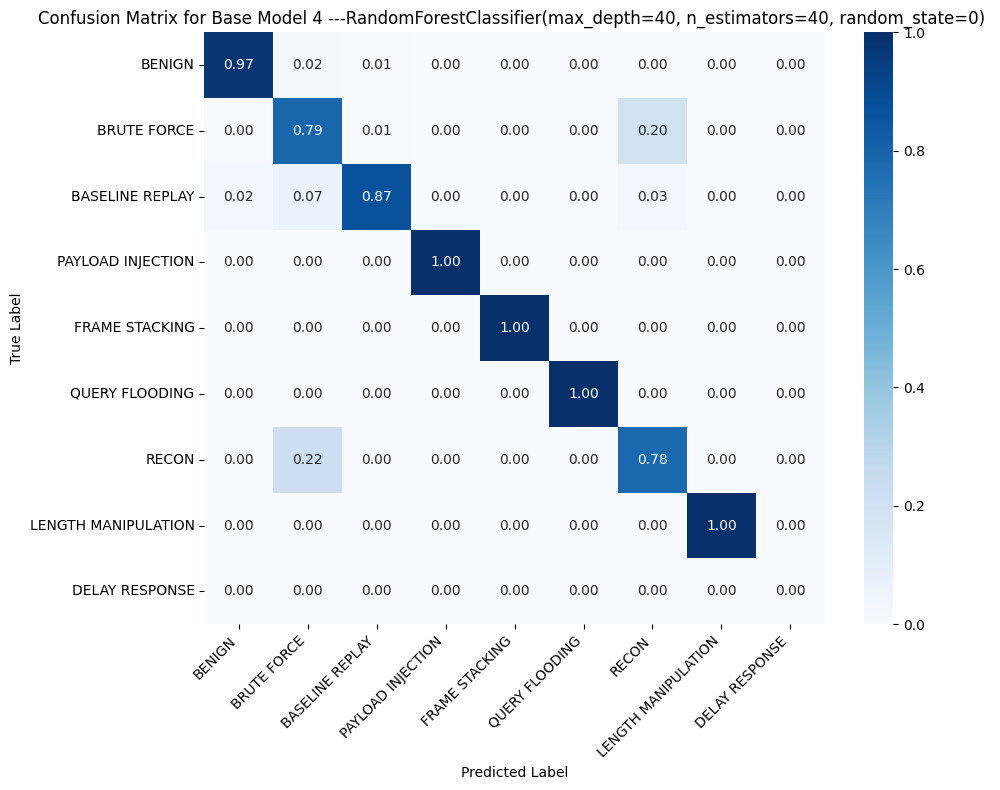


--- Training Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(max_depth=40, random_state=0)  0.8905
                     precision    recall  f1-score   support

             BENIGN       1.00      0.94      0.96    132444
        BRUTE FORCE       0.96      0.78      0.86     54640
    BASELINE REPLAY       0.03      0.85      0.05        86
  PAYLOAD INJECTION       0.99      1.00      0.99        75
     FRAME STACKING       0.52      1.00      0.68        61
     QUERY FLOODING       0.02      1.00      0.04        52
              RECON       0.00      0.81      0.00        32
LENGTH MANIPULATION       0.03      1.00      0.06        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.89    187445
          macro avg       0.44      0.92      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


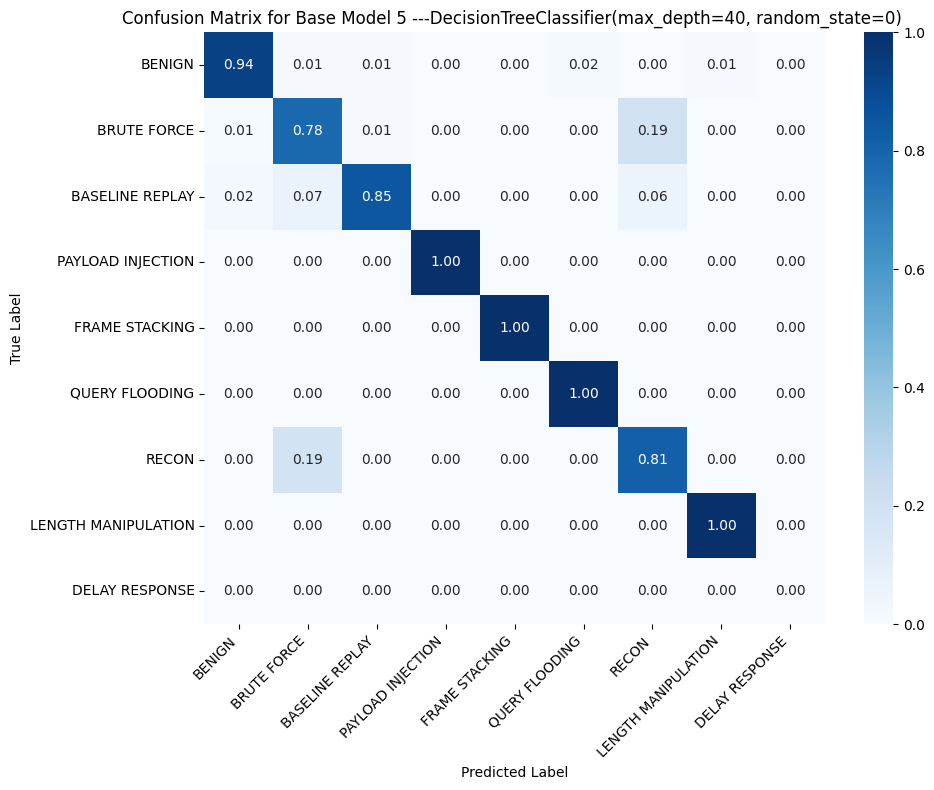


--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)  0.8988
                     precision    recall  f1-score   support

             BENIGN       1.00      0.94      0.97    132444
        BRUTE FORCE       0.95      0.79      0.87     54640
    BASELINE REPLAY       0.02      0.88      0.04        86
  PAYLOAD INJECTION       0.99      1.00      0.99        75
     FRAME STACKING       0.39      1.00      0.56        61
     QUERY FLOODING       0.03      1.00      0.05        52
              RECON       0.00      0.78      0.00        32
LENGTH MANIPULATION       0.05      1.00      0.09        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=4)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=4) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=4)  0.9064
                     precision    recall  f1-score   support

             BENIGN       0.99      0.98      0.98    132444
        BRUTE FORCE       0.96      0.73      0.83     54640
    BASELINE REPLAY       0.02      0.77      0.05        86
  PAYLOAD INJECTION       0.23      0.99      0.37        75
     FRAME STACKING       0.98      0.98      0.98        61
     QUERY FLOODING       0.98      1.00      0.99        52
              RECON       0.00      0.66      0.00        32
LENGTH MANIPULATION       0.32      1.00      0.48        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.91    187445
          macro avg       0.56      0.89      0.59    187445
       weighted avg       0.98      0.

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



--- Training Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(max_iter=40, random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(max_iter=40, random_state=0)  0.9243
                     precision    recall  f1-score   support

             BENIGN       1.00      0.97      0.99    132444
        BRUTE FORCE       0.96      0.80      0.87     54640
    BASELINE REPLAY       0.05      0.88      0.10        86
  PAYLOAD INJECTION       1.00      1.00      1.00        75
     FRAME STACKING       0.98      1.00      0.99        61
     QUERY FLOODING       0.19      1.00      0.32        52
              RECON       0.00      0.88      0.01        32
LENGTH MANIPULATION       0.28      1.00      0.44        55
     DELAY RESPONSE        nan       nan       nan         0

           accuracy                           0.92    187445
          macro avg       0

/tmp/ipykernel_108036/1471214638.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [87]:
### Train on the balanced undersample istribution
train_evaluate(base_models,X_upsampled,X_val,y_upsampled,y_val,train_dataset.label_encoder)